In [ ]:
from google.colab import auth
from google.oauth2 import service_account
from googleapiclient.discovery import build

auth.authenticate_user()

In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

scope = ['https://www.googleapis.com/auth/spreadsheets']
creds = ServiceAccountCredentials.from_json_keyfile_name('credentials.json', scope)

client = gspread.authorize(creds)

spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1CatLlB4axdBW0uJRoioR-x00RsPzQ54CFYq1PqzgV7E/edit?usp=drive_web&ouid=107190373735789167396'
sheet = client.open_by_url(spreadsheet_url)

worksheet = sheet.get_worksheet(0)
data = worksheet.get_all_records()
df_synthetic = pd.DataFrame(data)

df_synthetic.head()

In [ ]:
import pandas as pd

# Load the data file (adjust file name and method if it's an Excel file)
df = pd.read_csv('prolific_responses_survey2.csv')

# Define the mapping from Likert-scale text to numbers
likert_mapping = {
    "Not at all harmful": 1,
    "Slightly harmful": 2,
    "Moderately harmful": 3,
    "Very harmful": 4,
    "Extremely harmful": 5
}

# List the columns that contain Likert-scale responses.
# Update this list to include all columns that need conversion.
likert_columns = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

# Replace the text values with numeric values in those columns
for col in likert_columns:
    if col in df.columns:  # only replace if column exists in the dataframe
        df[col] = df[col].replace(likert_mapping)

In [ ]:
import pandas as pd

# Assuming the DataFrame is called df and has columns:
# ["ProlificID", "SyntheticPersonID", "AttnCheck", "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8", "Condition"]

# 1) Group by SyntheticPersonID and compute the mean for Q1..Q8
df_avg = (
    df.groupby("SyntheticPersonID")[["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8", "Certainty"]]
      .mean()  # average across repeated rows for each SyntheticPersonID
      .reset_index()
)

# 2) (Optional) If expecting a single "avg_harm" column across Q1..Q8
df_avg["avg_harm"] = df_avg[["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]].mean(axis=1)

print(df_avg.head())

In [ ]:
import pandas as pd
import itertools
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

# 1) Group by SyntheticPersonID and Condition, averaging Q1..Q8
#    for repeated rows of the same SyntheticPersonID.
grouped_df = (
    df.groupby(["SyntheticPersonID", "Condition"])[["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8", "Certainty"]]
      .mean()
      .reset_index()
)

# 2) Identify the questions you to test separately
questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]

# 3) Get the unique conditions
conditions = grouped_df["Condition"].unique()

# 4) Prepare a list to store results from each test
results = []

# 5) For each question, do pairwise t-tests across all condition pairs
for question in questions:
    for cond1, cond2 in itertools.combinations(conditions, 2):
        # Extract data for this question, for each condition
        group1 = grouped_df.loc[grouped_df["Condition"] == cond1, question].dropna()
        group2 = grouped_df.loc[grouped_df["Condition"] == cond2, question].dropna()

        # Perform Welch's t-test (equal_var=False)
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)

        # Store the results
        results.append((question, cond1, cond2, t_stat, p_val))

# 6) Convert results to a DataFrame
results_df = pd.DataFrame(
    results,
    columns=["Question", "Condition1", "Condition2", "t_stat", "p_value"]
)

# 7) Apply Bonferroni correction across all tests (all questions, all pairs)
adjusted = multipletests(results_df["p_value"], method="bonferroni")
results_df["p_adjusted"] = adjusted[1]

# 8) Print the final results
print("Separate t-test results for each question (with Bonferroni correction):")
print(results_df)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# Dictionary mapping question codes to descriptive labels
custom_labels = {
    'Q1': 'Hackers/Cybercriminals',
    'Q2': 'Government',
    'Q3': 'Corporations',
    'Q4': 'Employer/Colleagues',
    'Q5': 'Family',
    'Q6': 'Close Friends',
    'Q7': 'Acquaintances',
    'Q8': 'Publicly Available'
}

# Assume `grouped_df` has one row per (SyntheticPersonID, Condition),
# with columns: ["SyntheticPersonID", "Condition", "Q1", "Q2", ..., "Q8"].

questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]
conditions = grouped_df["Condition"].unique()

for cond in conditions:
    # Filter data for this condition
    cond_data = grouped_df[grouped_df["Condition"] == cond]

    # Compute means and standard deviations for each question
    mean_vals = cond_data[questions].mean(axis=0)
    std_vals  = cond_data[questions].std(axis=0)

    # Number of SyntheticPersonIDs in this condition
    n = cond_data.shape[0]

    # Standard error for each question
    se_vals = std_vals / np.sqrt(n)  # If n <= 1, be mindful of dividing by zero

    # 95% CI using the t-distribution (two-tailed)
    if n > 1:
        t_multiplier = st.t.ppf(1 - 0.025, df=n-1)
        ci_vals = t_multiplier * se_vals
    else:
        # If there's only one data point in this condition, CI is not meaningful
        ci_vals = np.zeros_like(se_vals)

    # X positions for plotting
    x_positions = np.arange(len(questions))

    # Create the plot
    plt.figure(figsize=(10,6))
    plt.errorbar(
        x_positions,
        mean_vals,
        yerr=ci_vals,
        fmt='o',
        capsize=5,
        color='blue',
        ecolor='black'
    )

    # Use custom labels for the questions
    question_labels = [custom_labels[q] for q in questions]

    plt.xticks(x_positions, question_labels, rotation=45, ha='right')
    plt.xlabel("Question")
    plt.ylabel("Mean Response")
    plt.title(f"Mean Response (95% CI) for Condition: {cond}")

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# Dictionary mapping question codes to descriptive labels
custom_labels = {
    'Q1': 'Hackers/Cybercriminals',
    'Q2': 'Government',
    'Q3': 'Corporations',
    'Q4': 'Employer/Colleagues',
    'Q5': 'Family',
    'Q6': 'Close Friends',
    'Q7': 'Acquaintances',
    'Q8': 'Publicly Available'
}

# Assume `grouped_df` has one row per (SyntheticPersonID, Condition),
# with columns: ["SyntheticPersonID", "Condition", "Q1", "Q2", ..., "Q8"].

questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]
conditions = grouped_df["Condition"].unique()

# Sort certainties if needed (e.g., 50, then 75)
certainties = grouped_df["Certainty"].unique()
certainties = sorted(certainties)

for cond in conditions:
    plt.figure(figsize=(10, 6))

    for i, cert in enumerate(certainties):
        subset = grouped_df[
            (grouped_df["Condition"] == cond) &
            (grouped_df["Certainty"] == cert)
        ]

        mean_vals = subset[questions].mean(axis=0)
        std_vals  = subset[questions].std(axis=0)
        n = subset.shape[0]
        se_vals = std_vals / np.sqrt(n) if n > 1 else np.zeros_like(std_vals)

        if n > 1:
            t_multiplier = st.t.ppf(1 - 0.025, df=n-1)
            ci_vals = t_multiplier * se_vals
        else:
            ci_vals = np.zeros_like(se_vals)

        x_positions = np.arange(len(questions))
        offset = i * 0.1
        shifted_positions = x_positions + offset

        plt.errorbar(
            shifted_positions,
            mean_vals,
            yerr=ci_vals,
            fmt='o',
            capsize=5,
            label=f"Certainty = {cert}%"
        )

    question_labels = [custom_labels[q] for q in questions]
    plt.xticks(np.arange(len(questions)), question_labels, rotation=45, ha='right', fontsize=18)
    plt.yticks(fontsize=18)

    plt.xlabel("Scenario", fontsize=18)
    plt.ylabel("Mean Response", fontsize=18)
    plt.title(f"Mean Response (95% CI) by Certainty for Condition: {cond}", fontsize=18)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(f'mean_response_{cond}.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# Assume grouped_df has one row per (SyntheticPersonID, Condition, Certainty) and columns for Q1..Q8, like:
# ["SyntheticPersonID", "Condition", "Certainty", "Q1", "Q2", ..., "Q8"]

questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]
conditions = grouped_df["Condition"].unique()
certainties = sorted(grouped_df["Certainty"].unique())  # e.g., [50, 75]

for question in questions:
    # Prepare lists to store the mean, CI, and x-axis labels
    means = []
    ci_vals = []
    x_labels = []

    # Loop over each Condition and Certainty combination
    for cond in conditions:
        for cert in certainties:
            # Filter rows that match the current Condition and Certainty
            subset = grouped_df.loc[
                (grouped_df["Condition"] == cond) & (grouped_df["Certainty"] == cert),
                question
            ].dropna()

            mean_val = subset.mean()
            std_val = subset.std()
            n = subset.shape[0]

            # Compute 95% CI using the t-distribution
            if n > 1:
                se_val = std_val / np.sqrt(n)
                t_multiplier = st.t.ppf(1 - 0.025, df=n-1)  # for a 95% CI
                ci = t_multiplier * se_val
            else:
                # If there's only one data point, the CI isn't meaningful
                ci = 0.0

            means.append(mean_val)
            ci_vals.append(ci)
            x_labels.append(f"{cond}-{int(cert)}%")  # e.g. "Health-50%" or "Control-75%"

    # X positions for plotting
    x_positions = np.arange(len(means))

    plt.figure(figsize=(10, 6))
    plt.errorbar(
        x_positions,
        means,
        yerr=ci_vals,
        fmt='o',
        capsize=5,
        color='blue',
        ecolor='black'
    )

    plt.xticks(x_positions, x_labels, rotation=45, ha='right')
    plt.xlabel("Condition - Certainty")
    plt.ylabel("Mean Response")
    plt.title(f"Mean {question} by Condition and Certainty (95% CI)")
    plt.tight_layout()
    plt.show()

In [ ]:
import scipy.stats as stats

score_types = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
conditions_of_interest = ["Health", "Control"]

for cond in conditions_of_interest:
    print(f"\n=== Condition: {cond} ===")

    # Subset the data for just this condition
    subset_cond = grouped_df[grouped_df["Condition"] == cond]

    for score in score_types:
        # Separate data for 50% vs 75% certainty
        data_50 = subset_cond[subset_cond["Certainty"] == 50][score].dropna()
        data_75 = subset_cond[subset_cond["Certainty"] == 75][score].dropna()

        # Only run a t-test if both groups have sufficient data
        if len(data_50) >= 2 and len(data_75) >= 2:
            t_stat, p_val = stats.ttest_ind(data_50, data_75, equal_var=False)
            print(f"{score} | t = {t_stat:.3f}, p = {p_val:.3e}")
        else:
            print(f"{score} | Not enough data for t-test.")

In [ ]:
df_responses = pd.read_csv('prolific_responses_survey2.csv')  # Adjust filename/path as needed
df_prolific  = pd.read_csv('prolific_export_survey2.csv')  # Adjust filename/path as needed
df_responses = df_responses.rename(columns={"ProlificID": "Participant id"})

demo_cols = ["Age","Sex","Ethnicity simplified","Country of birth","Country of residence",
             "Nationality","Language","Student status","Employment status"]
keep_cols = ["Participant id"] + [c for c in demo_cols if c in df_prolific.columns]

df_prolific = df_prolific[keep_cols].copy()
df_prolific = df_prolific.replace({"DATA_EXPIRED": pd.NA, "Data expired": pd.NA})
for c in keep_cols[1:]:
    if c in df_prolific:
        df_prolific[c] = df_prolific[c].astype("string").str.strip()

df_prolific = df_prolific.applymap(
    lambda v: pd.NA if isinstance(v, str) and v.strip().lower().replace(" ", "_") == "data_expired" else v
)

# Define the mapping from Likert-scale text to numbers
likert_mapping = {
    "Not at all harmful": 1,
    "Slightly harmful": 2,
    "Moderately harmful": 3,
    "Very harmful": 4,
    "Extremely harmful": 5
}

# List the columns that contain Likert-scale responses.
# Update this list to include all columns that need conversion.
likert_columns = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

# Replace the text values with numeric values in those columns
for col in likert_columns:
    if col in df.columns:  # only replace if column exists in the dataframe
        df_responses[col] = df_responses[col].replace(likert_mapping)

merged_df = df_responses.merge(df_prolific, on="Participant id", how="left")

# Now merged_df contains columns from both datasets.
print("Merged DataFrame:")
print(merged_df.head())

questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import itertools

# Define the questions and the demographic columns to analyze
questions = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

# List of demographic columns (categorical) from the Prolific export.
# Update this list based on the columns available in your prolific_export.
demographic_vars = ["Sex", "Ethnicity simplified", "Country of residence", "Language", "Employment status"]

# Prepare a list to store the t-test results
results = []

# Loop over each demographic variable
for demo in demographic_vars:
    # Get the unique groups in this demographic (drop missing values)
    groups = merged_df[demo].dropna().unique()

    # If there are less than 2 groups, skip this demographic.
    if len(groups) < 2:
        continue

    # For each question, perform pairwise comparisons between groups in this demographic.
    for question in questions:
        # Use itertools.combinations to get all unique pairwise comparisons.
        for group1, group2 in itertools.combinations(groups, 2):
            # Filter data for each group for the given question
            data1 = merged_df.loc[merged_df[demo] == group1, question].dropna()
            data2 = merged_df.loc[merged_df[demo] == group2, question].dropna()

            # Only perform the t-test if both groups have at least 2 observations
            if len(data1) >= 2 and len(data2) >= 2:
                t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            else:
                t_stat, p_val = np.nan, np.nan  # Not enough data

            results.append((demo, question, group1, group2, t_stat, p_val))

# Convert the results list to a DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=["Demographic", "Question", "Group1", "Group2", "t_stat", "p_value"])

# Optionally, adjust p-values for multiple comparisons using Bonferroni correction.
from statsmodels.stats.multitest import multipletests
adjusted = multipletests(results_df["p_value"].dropna(), method="bonferroni")
# Place adjusted p-values back into the results DataFrame.
# (needing to match the indices since multipletests was applied to non-NaN values.)
results_df.loc[results_df["p_value"].notna(), "p_adjusted"] = adjusted[1]

# Display the results
print("Pairwise t-test results for each question by demographic variable:")
print(results_df)
# get df to csv
results_df.to_csv('t-tests_survey2.csv', index=False)

## Supervised ML

In [ ]:
from sklearn.preprocessing import LabelEncoder

feature_list = ["GENDER", "RACETHN", "EDUCCAT5", "DIVISION", "MARITAL_ACS",
                "CHILDRENCAT", "CITIZEN_REC", "BORN_ACS", "AGE_INT",
                "HIV_STAT", "PREG_STAT", "NumChronicIllness",
                "FAMINC5", "CC_NUM", "FDSTMP_CPS",
                "SEXUALITY", "OWNGUN_GSS", "RELIGCAT", "Certainty"
]

In [ ]:
df_synthetic.head()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
import pandas as pd

df_merged = pd.merge(
    df_synthetic,
    df_avg,
    how="left",
    left_on="id",
    right_on="SyntheticPersonID",
    suffixes=("", "_drop")
)

cols_to_drop = [col for col in df_merged.columns if col.endswith("_drop")]
df_final = df_merged.drop(columns=cols_to_drop)
df_final = df_final.fillna(0)

print(df_final.head())

In [ ]:
# for the rows where Certainty is 0, randomly assign them a value of 50 or 75
df_final.loc[df_final['Certainty'] == 0, 'Certainty'] = np.random.choice([50, 75], size=df_final.loc[df_final['Certainty'] == 0].shape[0])

In [40]:
train_data = df_final[df_final['Q1'] > 0]
predict_data = df_final[df_final['Q1'] == 0]

X_train = train_data[feature_list]
y_train = train_data['Q1']

onehot_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore',
    drop='first'
)

X_train_encoded = onehot_encoder.fit_transform(X_train.astype(str))

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

models = [
    ('RandomForest', RandomForestRegressor(n_estimators=100)),
    ('GradientBoosting', GradientBoostingRegressor()),
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('DecisionTree', DecisionTreeRegressor()),
    ('SVR', SVR())
]

def evaluate_model(model_name, model, X_train, y_train):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    r2 = r2_score(y_train, y_train_pred)
    print(f'Model: {model_name}')
    print(f'MSE on training data: {mse}')
    print(f'R^2 on training data: {r2}\n')

for name, model in models:
    evaluate_model(name, model, X_train_encoded, y_train_scaled)

Model: RandomForest
MSE on training data: 0.14594337127736381
R^2 on training data: 0.8540566287226362

Model: GradientBoosting
MSE on training data: 0.8644046778033457
R^2 on training data: 0.13559532219665427

Model: LinearRegression
MSE on training data: 0.12443103062698671
R^2 on training data: 0.8755689693730133

Model: Ridge
MSE on training data: 0.3498706291084605
R^2 on training data: 0.6501293708915394

Model: Lasso
MSE on training data: 1.0
R^2 on training data: 0.0

Model: DecisionTree
MSE on training data: 8.06573668438865e-34
R^2 on training data: 1.0

Model: SVR
MSE on training data: 0.6157409795108677
R^2 on training data: 0.3842590204891323



In [41]:
questions = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
for q in questions:

  train_data = df_final[df_final[q] > 0]
  predict_data = df_final[df_final[q] == 0]

  X_train = train_data[feature_list]
  y_train = train_data[q]

  onehot_encoder = OneHotEncoder(
      sparse_output=False,
      handle_unknown='ignore',
      drop='first'
  )

  X_train_encoded = onehot_encoder.fit_transform(X_train.astype(str))

  scaler = StandardScaler()
  y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

  models = [
      ('DecisionTree', DecisionTreeRegressor())
  ]

  def evaluate_model(model_name, model, X_train, y_train):
      model.fit(X_train, y_train)
      y_train_pred = model.predict(X_train)
      mse = mean_squared_error(y_train, y_train_pred)
      r2 = r2_score(y_train, y_train_pred)
      print(f'Model: {model_name}')
      print(f'MSE on training data: {mse}')
      print(f'R^2 on training data: {r2}\n')

  for name, model in models:
      evaluate_model(name, model, X_train_encoded, y_train_scaled)


  best_model = DecisionTreeRegressor(
      max_depth=30,
      max_features=None,
      min_samples_leaf=4,
      min_samples_split=5,
      random_state=42
  )
  best_model.fit(X_train_encoded, y_train_scaled)

  X_predict = predict_data[feature_list]
  X_predict_encoded = onehot_encoder.transform(X_predict.astype(str))
  predicted_scores_scaled = best_model.predict(X_predict_encoded)

  predicted_scores = scaler.inverse_transform(predicted_scores_scaled.reshape(-1, 1)).flatten()

  df_final.loc[df_final[q] == 0, q] = predicted_scores

  print(df_final.head())

Model: DecisionTree
MSE on training data: 6.400458912926002e-34
R^2 on training data: 1.0



/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.583333   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  4.187500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

    Q2   Q3   Q4   Q5   Q6   Q7   Q8 Certainty avg_harm  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      75.0

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.583333   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  4.187500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

         Q2   Q3   Q4   Q5   Q6   Q7   Q8 Certainty avg_harm  
0  3.562500  0.0  0.0  0.0  0.0  0.0  0.0

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.583333   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  4.187500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

         Q2        Q3   Q4   Q5   Q6   Q7   Q8 Certainty avg_harm  
0  3.562500  3.266667  0.0  0.0  0.0

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.583333   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  4.187500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

         Q2        Q3        Q4   Q5   Q6   Q7   Q8 Certainty avg_harm  
0  3.562500  3.266667  2.770833

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.583333   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  4.187500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

         Q2        Q3        Q4        Q5   Q6   Q7   Q8 Certainty avg_harm  
0  3.562500  3.266667  2.7

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.583333   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  4.187500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

         Q2        Q3        Q4        Q5        Q6   Q7   Q8 Certainty  \
0  3.562500  3.266667  2.7708

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.583333   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  4.187500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

         Q2        Q3        Q4        Q5        Q6        Q7   Q8 Certainty  \
0  3.562500  3.266667  2

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [42]:
# drop syntheticpersonid column
df_final = df_final.drop(columns=['SyntheticPersonID'])

## Graphs

/tmp/ipython-input-4269703244.py:31: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax0 = sns.barplot(
/tmp/ipython-input-4269703244.py:46: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax1 = sns.barplot(


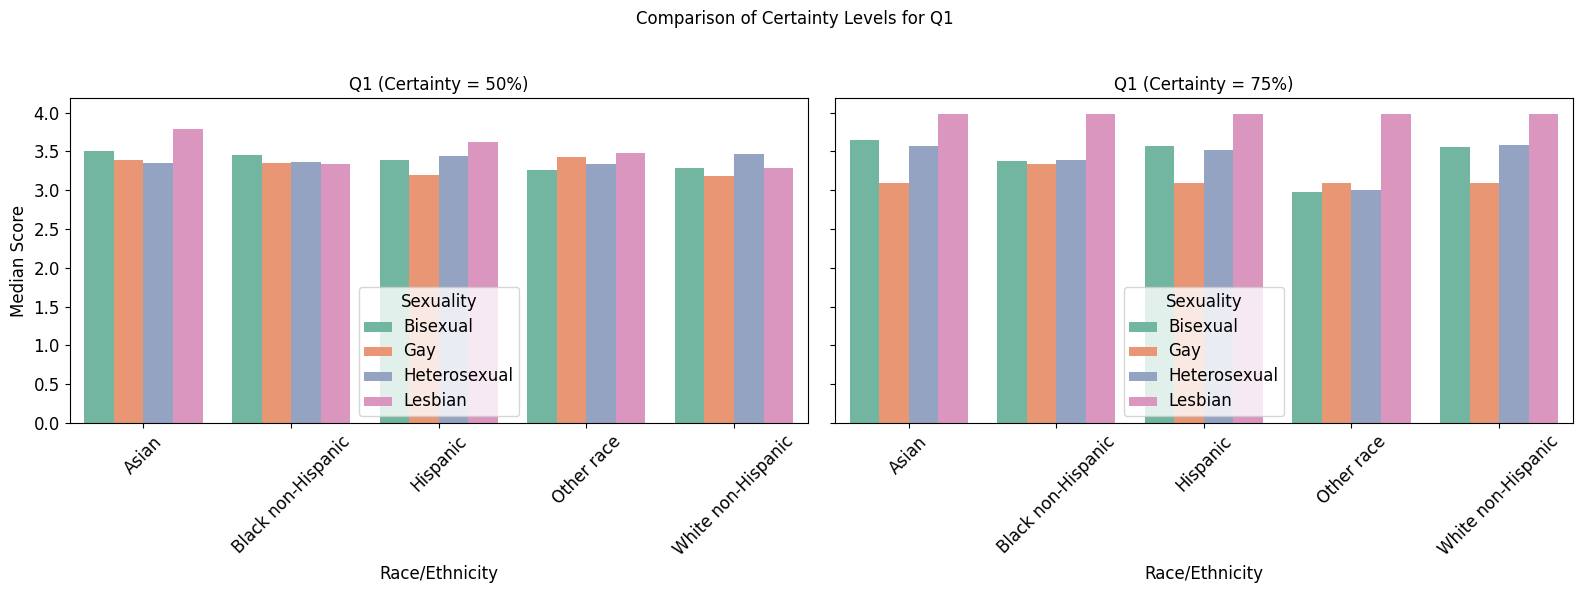

/tmp/ipython-input-4269703244.py:31: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax0 = sns.barplot(
/tmp/ipython-input-4269703244.py:46: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax1 = sns.barplot(


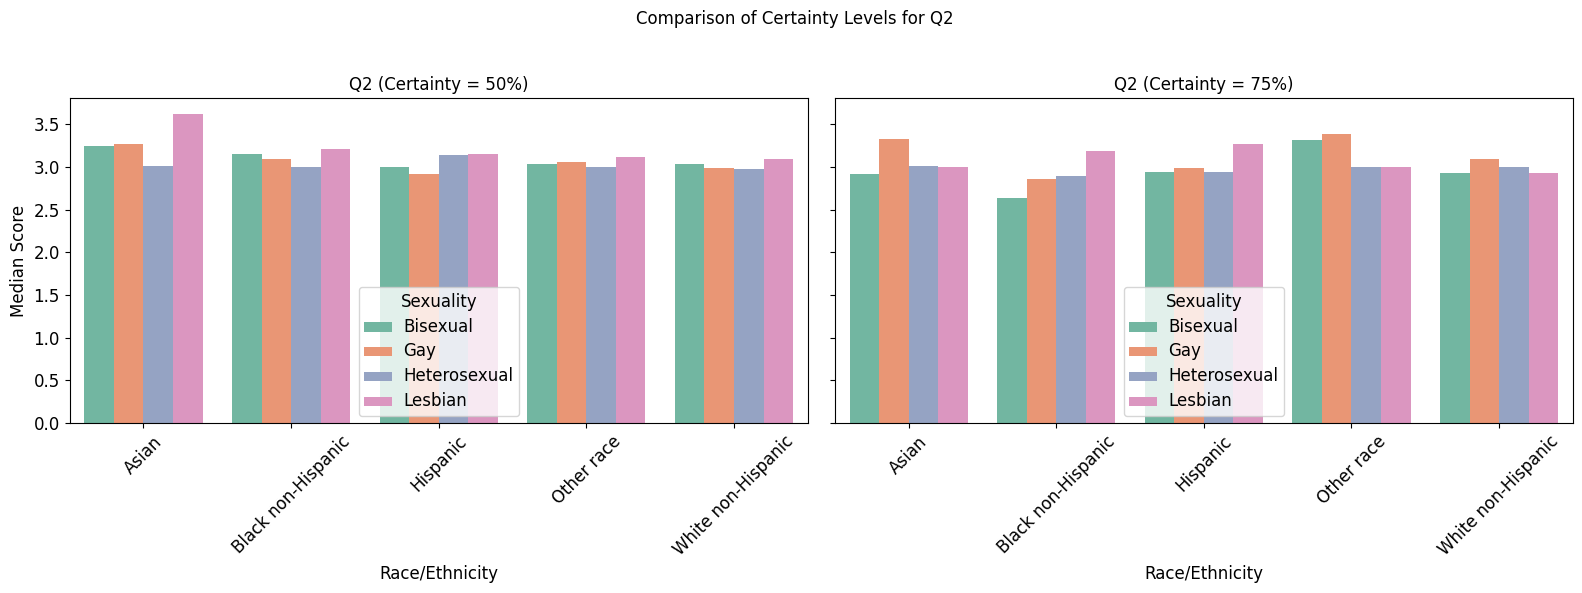

/tmp/ipython-input-4269703244.py:31: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax0 = sns.barplot(
/tmp/ipython-input-4269703244.py:46: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax1 = sns.barplot(


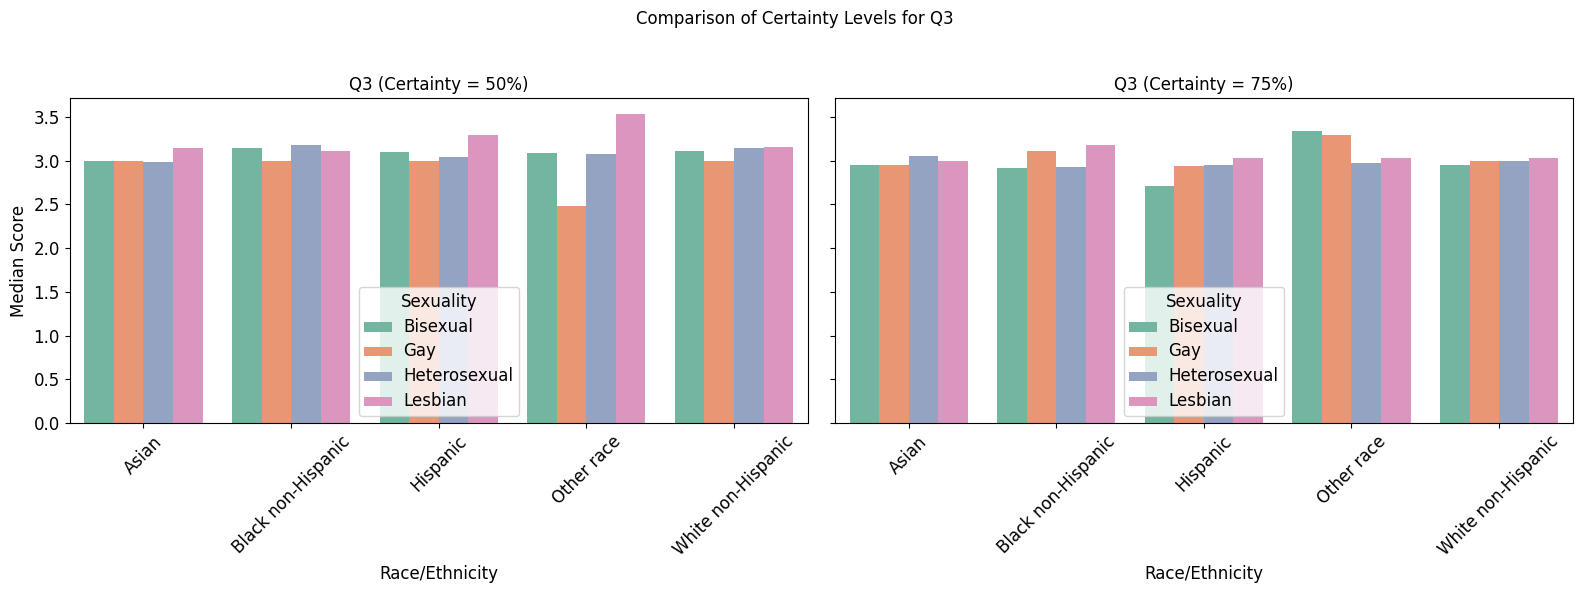

/tmp/ipython-input-4269703244.py:31: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax0 = sns.barplot(
/tmp/ipython-input-4269703244.py:46: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax1 = sns.barplot(


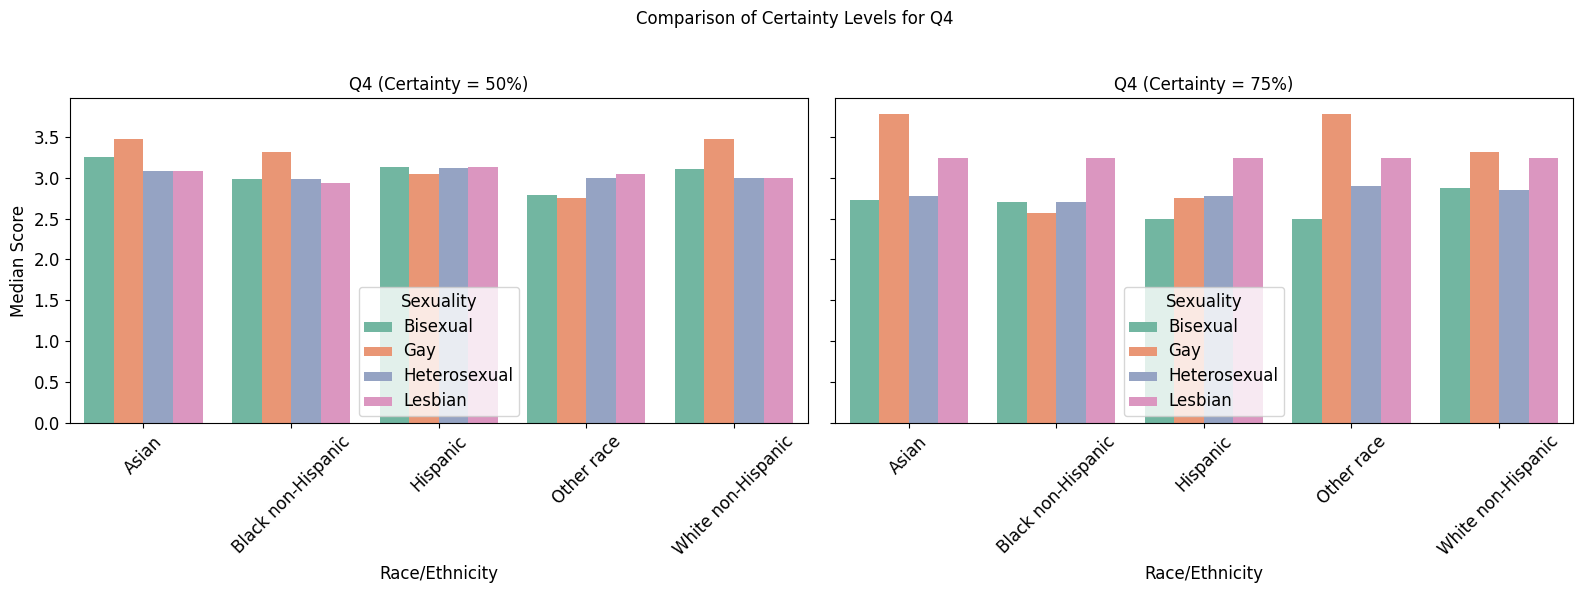

/tmp/ipython-input-4269703244.py:31: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax0 = sns.barplot(
/tmp/ipython-input-4269703244.py:46: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax1 = sns.barplot(


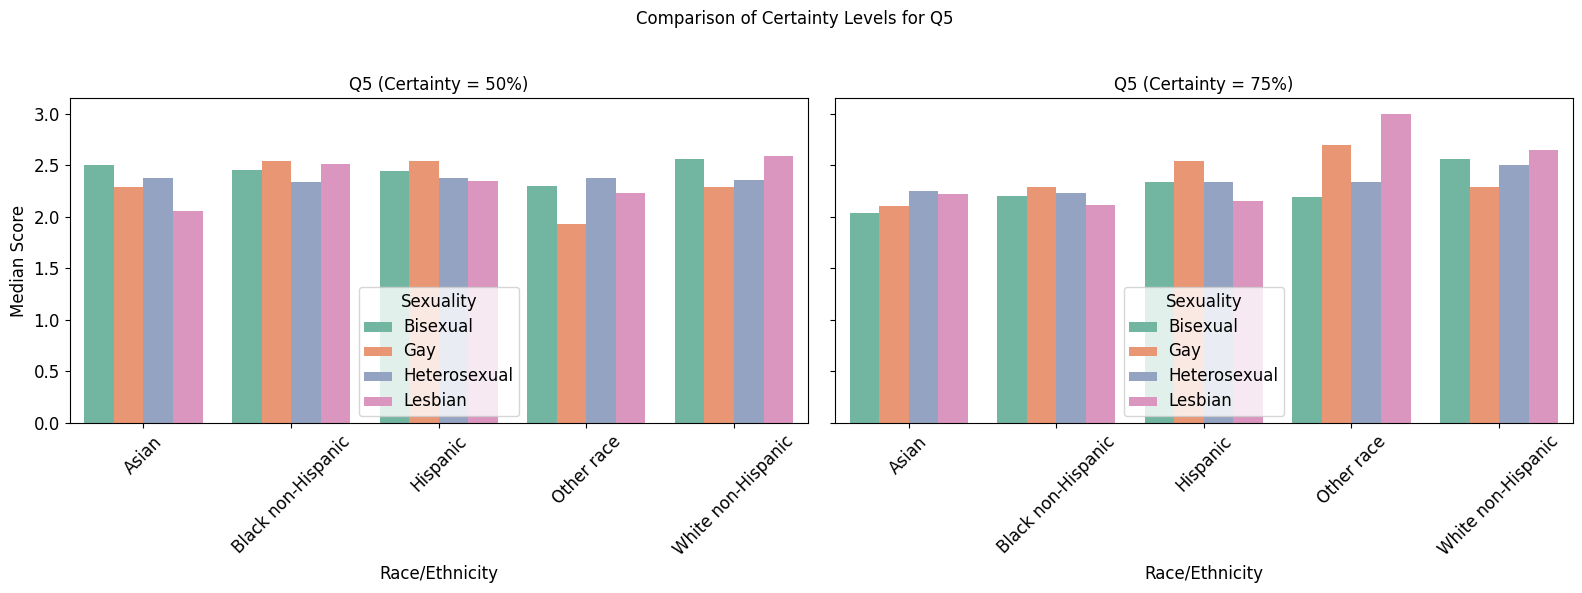

/tmp/ipython-input-4269703244.py:31: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax0 = sns.barplot(
/tmp/ipython-input-4269703244.py:46: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax1 = sns.barplot(


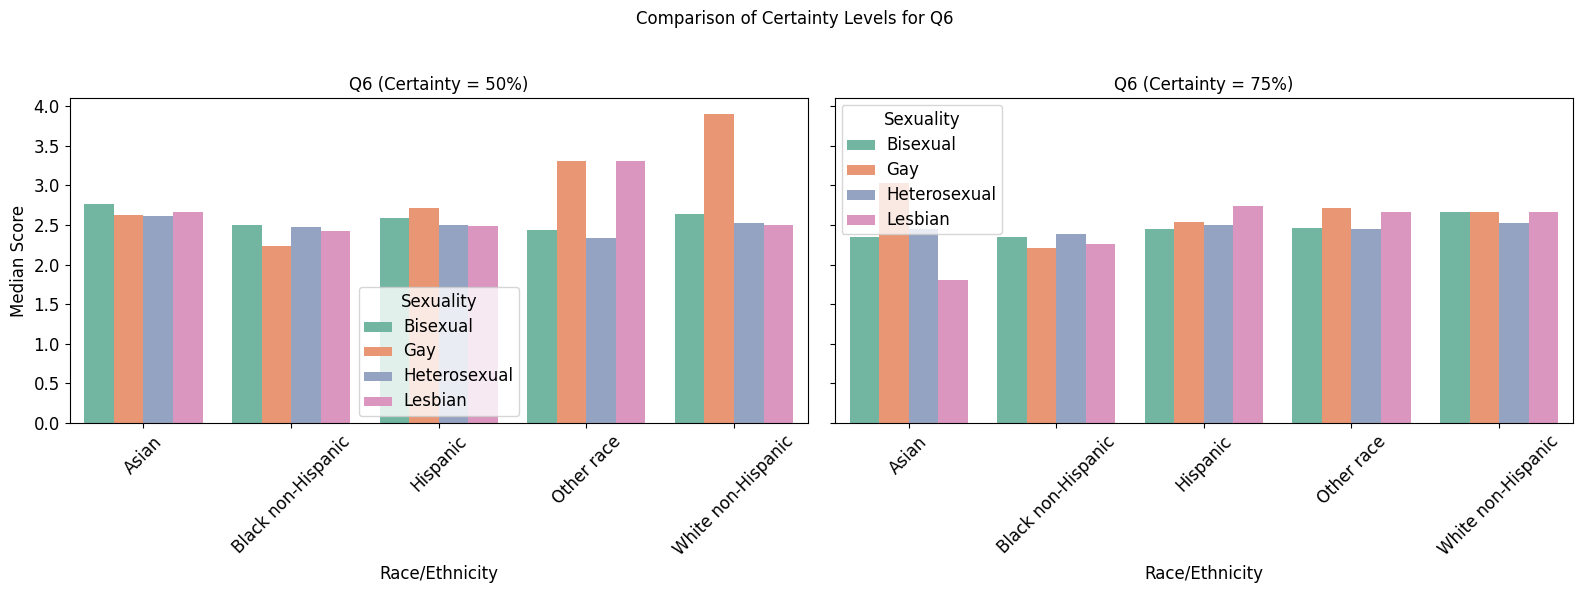

/tmp/ipython-input-4269703244.py:31: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax0 = sns.barplot(
/tmp/ipython-input-4269703244.py:46: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax1 = sns.barplot(


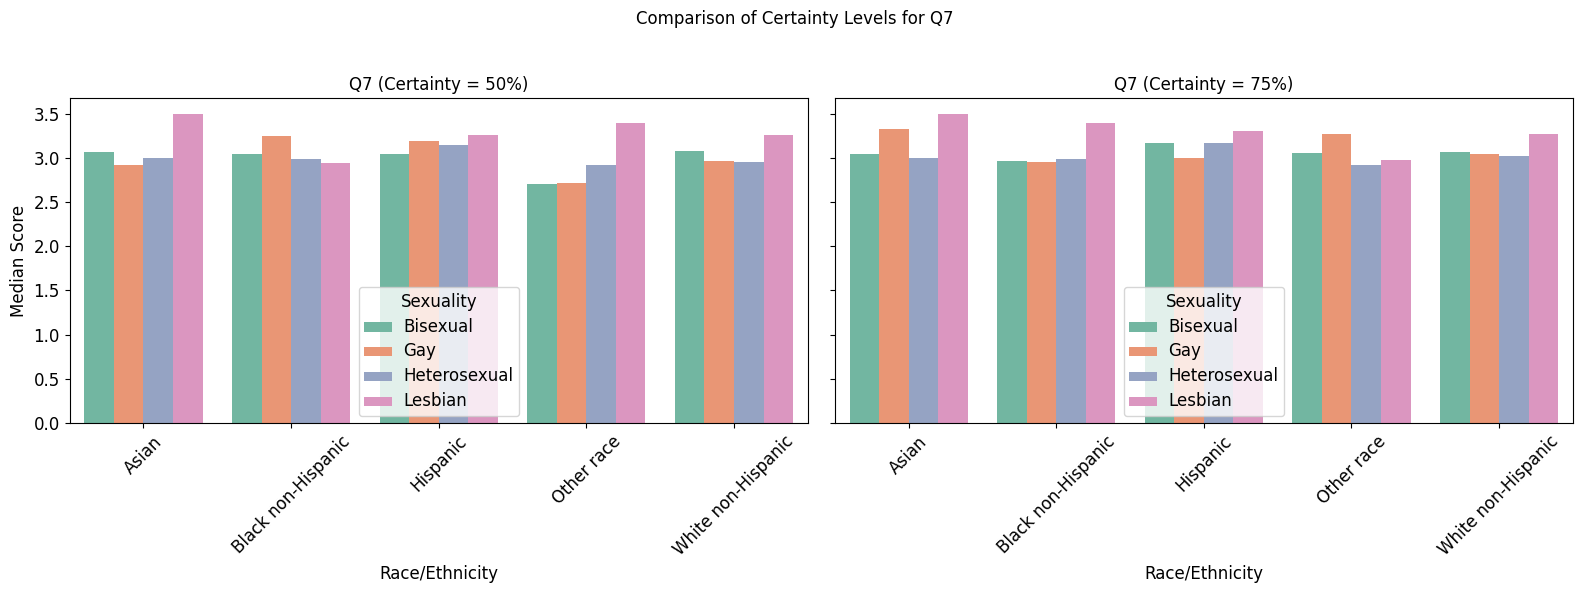

/tmp/ipython-input-4269703244.py:31: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax0 = sns.barplot(
/tmp/ipython-input-4269703244.py:46: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax1 = sns.barplot(


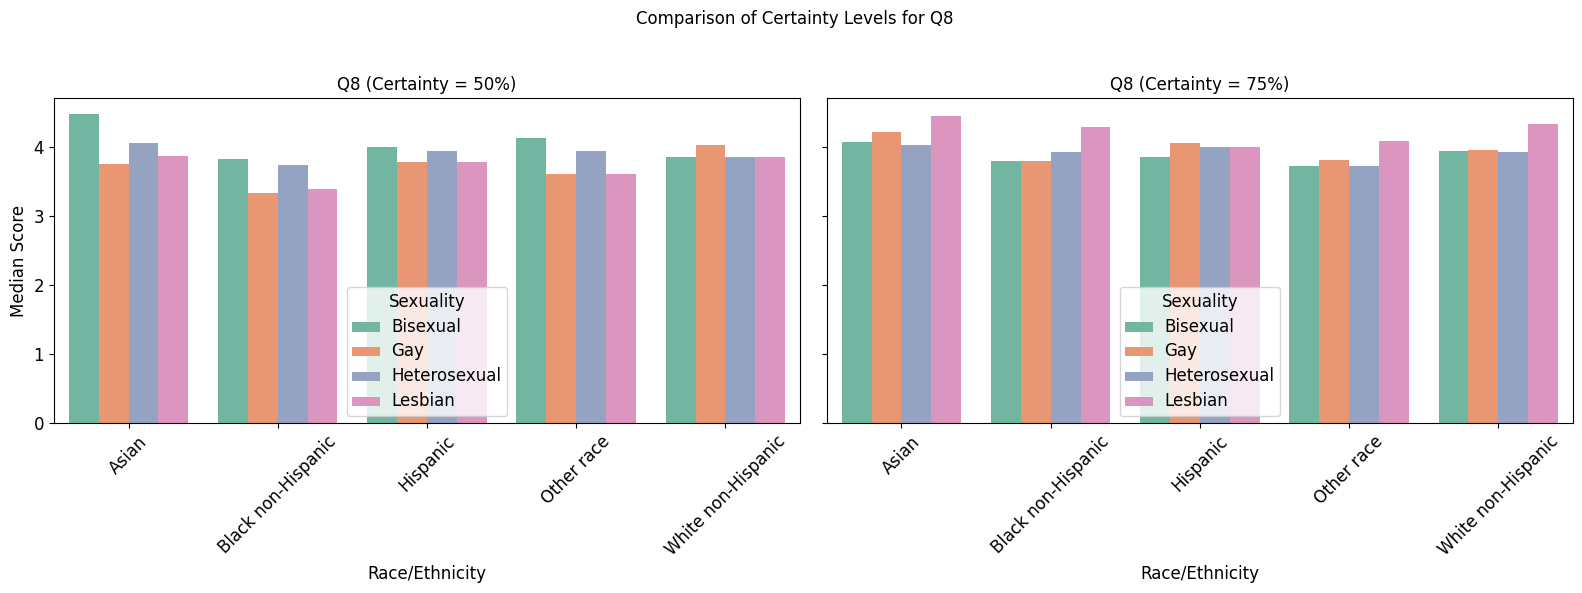

Saved ./Barplots_Certainty.pdf


In [45]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_barplot_certainty_side_by_side(df, questions, save=False, outdir=".", fontsize=12, figsize=(16, 6), dpi=100, save_dpi=300):
    palette = sns.color_palette("Set2")
    pdf = None
    if save:
        os.makedirs(outdir, exist_ok=True)
        pdf_path = f"{outdir}/Barplots_Certainty.pdf"
        pdf = PdfPages(pdf_path)

    for score in questions:
        df_50 = df[df['Certainty'] == 50]
        df_75 = df[df['Certainty'] == 75]

        average_scores_50 = (
            df_50.groupby(['RACETHN', 'SEXUALITY'])[score]
            .median()
            .reset_index()
        )
        average_scores_75 = (
            df_75.groupby(['RACETHN', 'SEXUALITY'])[score]
            .median()
            .reset_index()
        )

        fig, axes = plt.subplots(1, 2, figsize=figsize, dpi=dpi, sharey=True)

        ax0 = sns.barplot(
            x='RACETHN', y=score, hue='SEXUALITY',
            data=average_scores_50, palette=palette, ax=axes[0]
        )
        ax0.set_title(f'{score} (Certainty = 50%)', fontsize=fontsize)
        ax0.set_xlabel('Race/Ethnicity', fontsize=fontsize)
        ax0.set_ylabel('Median Score', fontsize=fontsize)
        ax0.tick_params(axis='both', labelsize=fontsize)
        axes[0].tick_params(axis='x', rotation=45)
        leg0 = ax0.legend(title='Sexuality')
        if leg0:
            leg0.get_title().set_fontsize(fontsize)
            for t in leg0.get_texts():
                t.set_fontsize(fontsize)

        ax1 = sns.barplot(
            x='RACETHN', y=score, hue='SEXUALITY',
            data=average_scores_75, palette=palette, ax=axes[1]
        )
        ax1.set_title(f'{score} (Certainty = 75%)', fontsize=fontsize)
        ax1.set_xlabel('Race/Ethnicity', fontsize=fontsize)
        ax1.set_ylabel('Median Score', fontsize=fontsize)
        ax1.tick_params(axis='both', labelsize=fontsize)
        axes[1].tick_params(axis='x', rotation=45)
        leg1 = ax1.legend(title='Sexuality')
        if leg1:
            leg1.get_title().set_fontsize(fontsize)
            for t in leg1.get_texts():
                t.set_fontsize(fontsize)

        plt.suptitle(f'Comparison of Certainty Levels for {score}', fontsize=fontsize)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if save:
            pdf.savefig(fig, bbox_inches="tight", dpi=save_dpi)

        plt.show()
        plt.close(fig)

    if save:
        pdf.close()
        print(f"Saved {pdf_path}")

# --- Example usage ---
questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]
plot_barplot_certainty_side_by_side(df_final, questions, save=True, outdir=".")

/tmp/ipython-input-2997694932.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_50.groupby(["DIVISION", "FAMINC5"])[score]
/tmp/ipython-input-2997694932.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_75.groupby(["DIVISION", "FAMINC5"])[score]


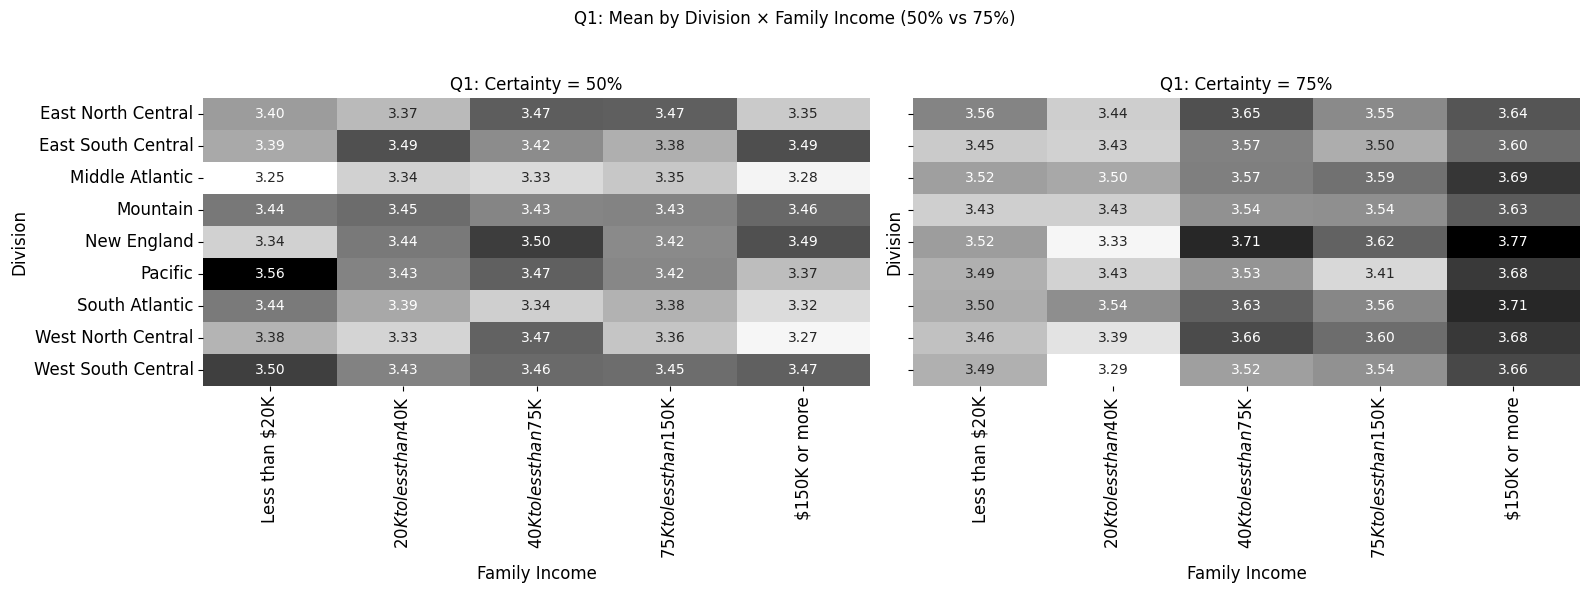

/tmp/ipython-input-2997694932.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_50.groupby(["DIVISION", "FAMINC5"])[score]
/tmp/ipython-input-2997694932.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_75.groupby(["DIVISION", "FAMINC5"])[score]


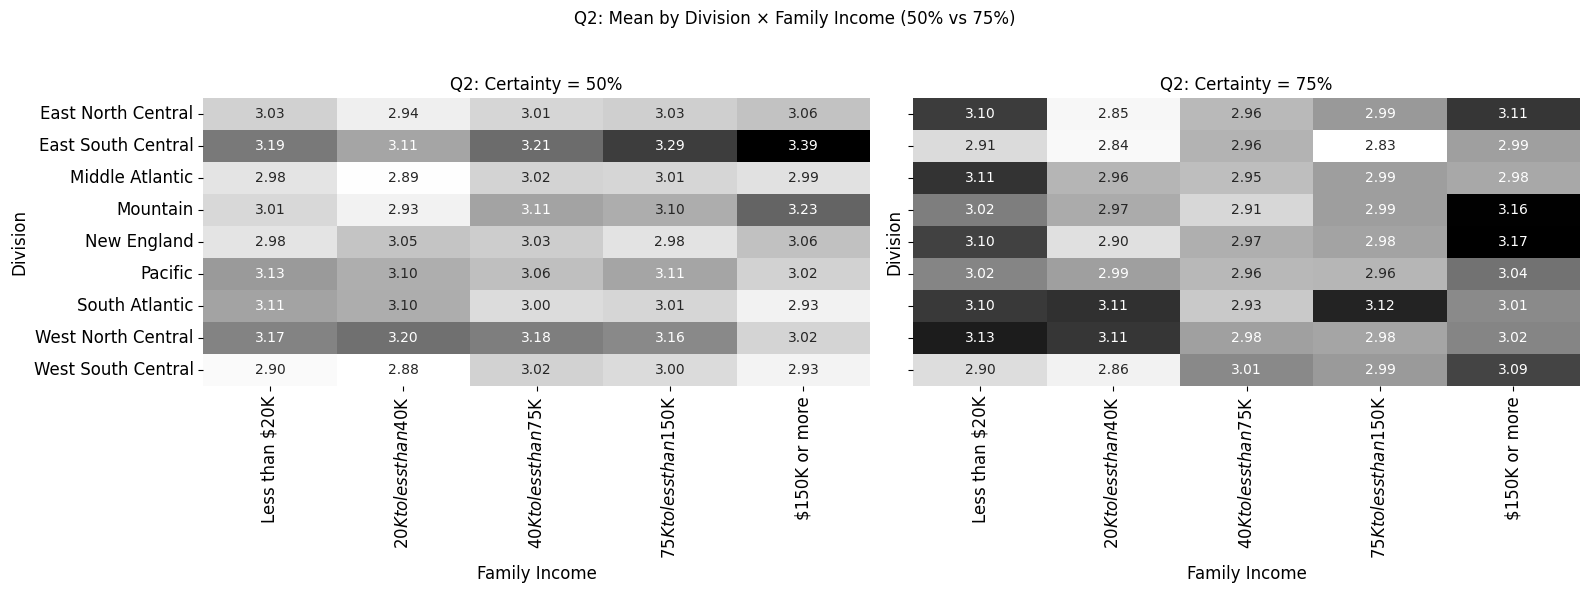

/tmp/ipython-input-2997694932.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_50.groupby(["DIVISION", "FAMINC5"])[score]
/tmp/ipython-input-2997694932.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_75.groupby(["DIVISION", "FAMINC5"])[score]


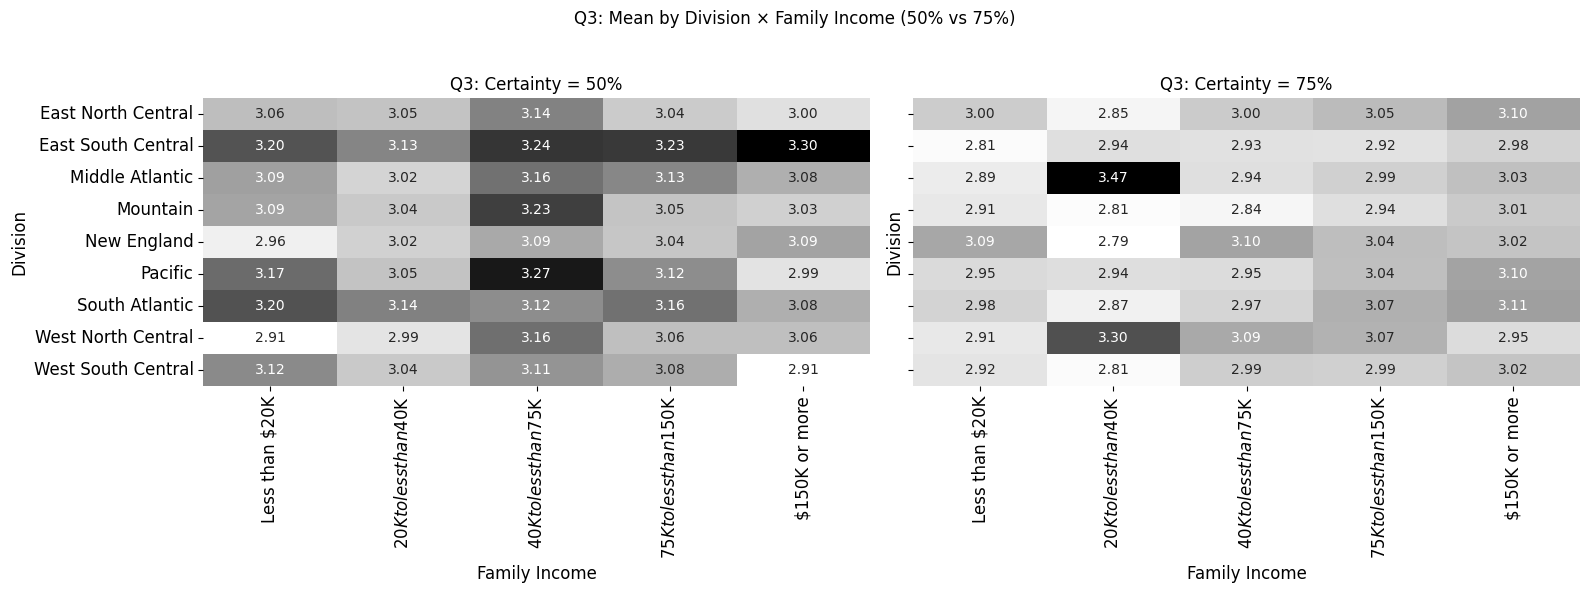

/tmp/ipython-input-2997694932.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_50.groupby(["DIVISION", "FAMINC5"])[score]
/tmp/ipython-input-2997694932.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_75.groupby(["DIVISION", "FAMINC5"])[score]


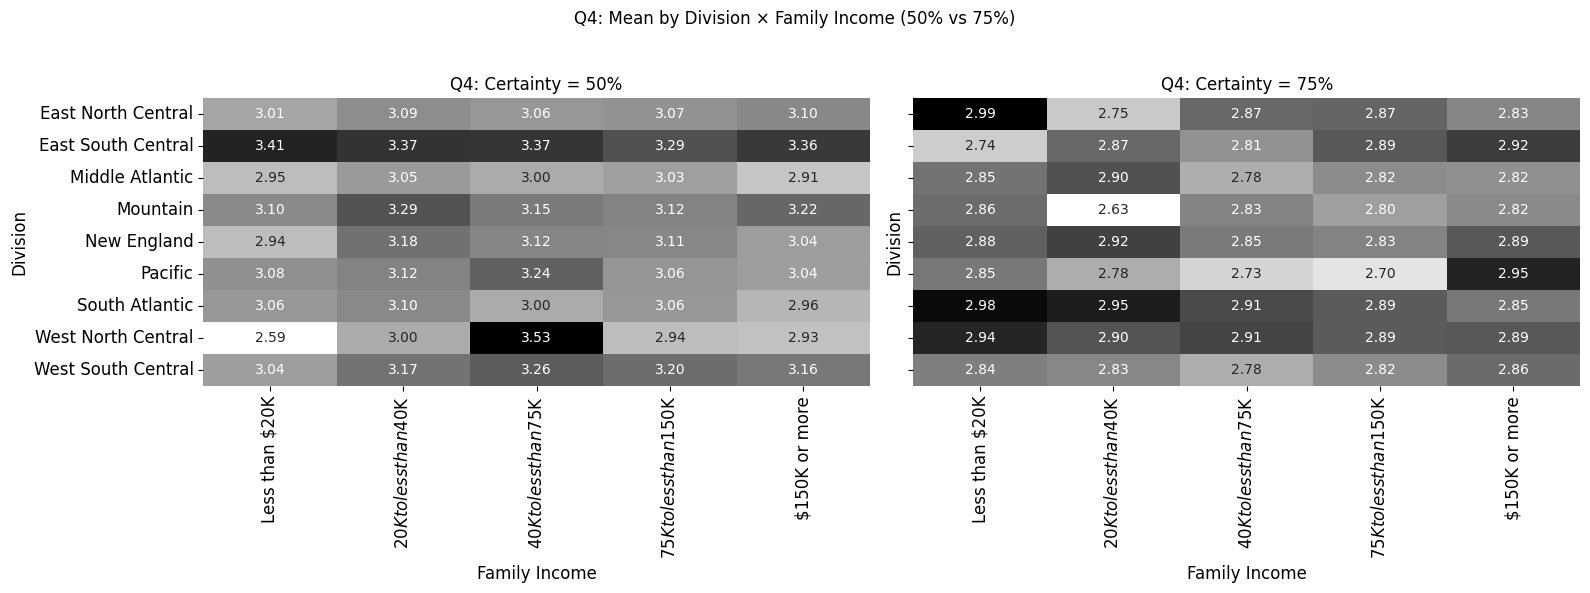

/tmp/ipython-input-2997694932.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_50.groupby(["DIVISION", "FAMINC5"])[score]
/tmp/ipython-input-2997694932.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_75.groupby(["DIVISION", "FAMINC5"])[score]


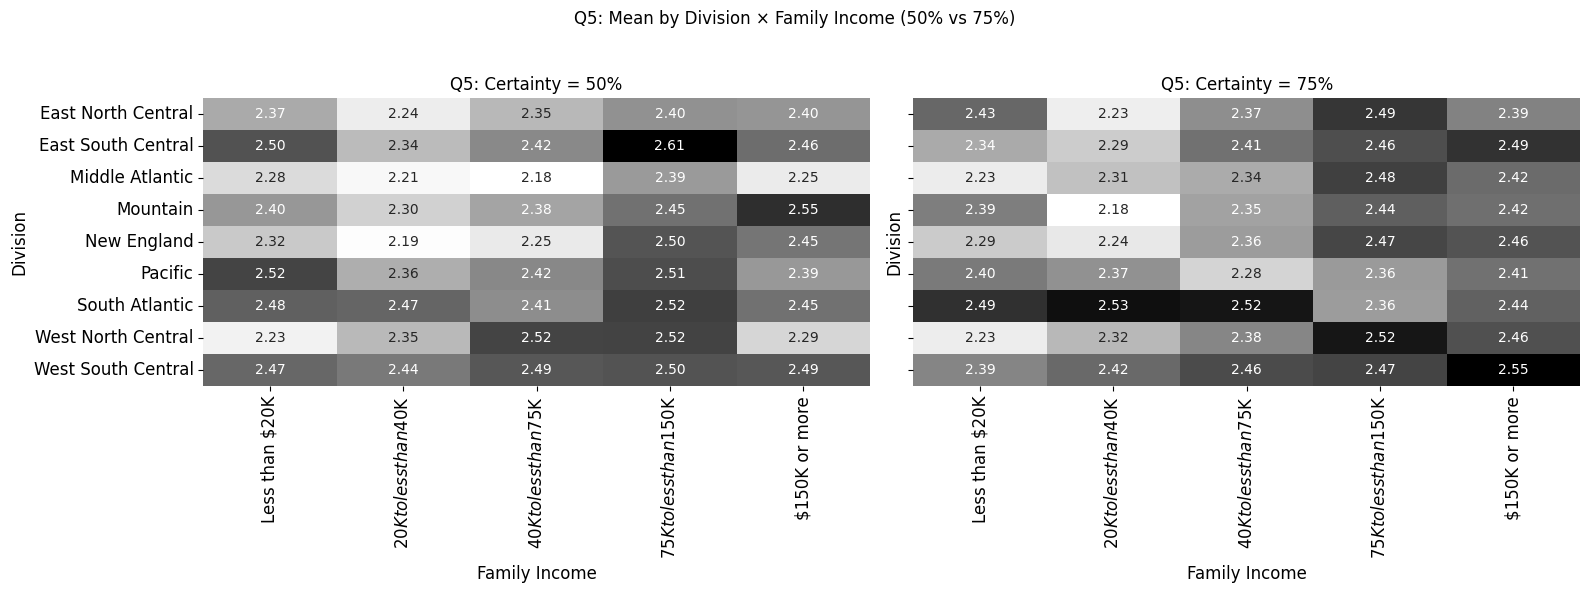

/tmp/ipython-input-2997694932.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_50.groupby(["DIVISION", "FAMINC5"])[score]
/tmp/ipython-input-2997694932.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_75.groupby(["DIVISION", "FAMINC5"])[score]


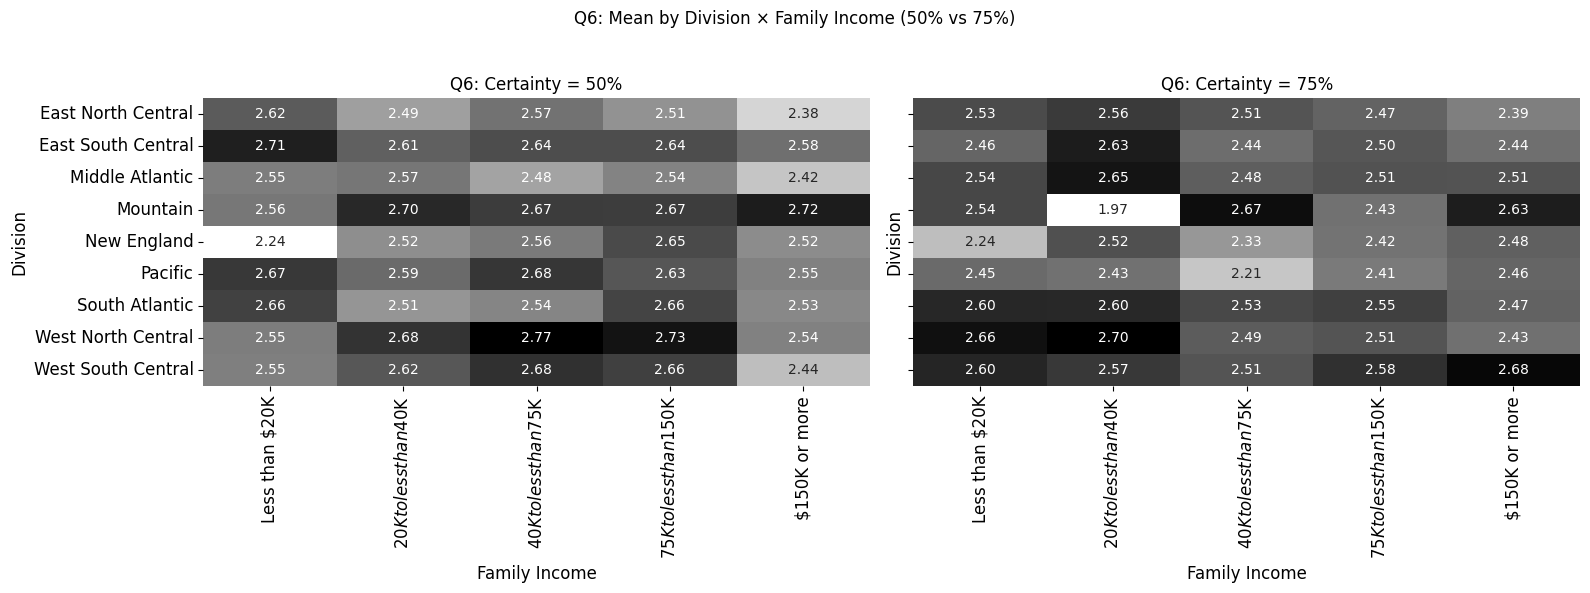

/tmp/ipython-input-2997694932.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_50.groupby(["DIVISION", "FAMINC5"])[score]
/tmp/ipython-input-2997694932.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_75.groupby(["DIVISION", "FAMINC5"])[score]


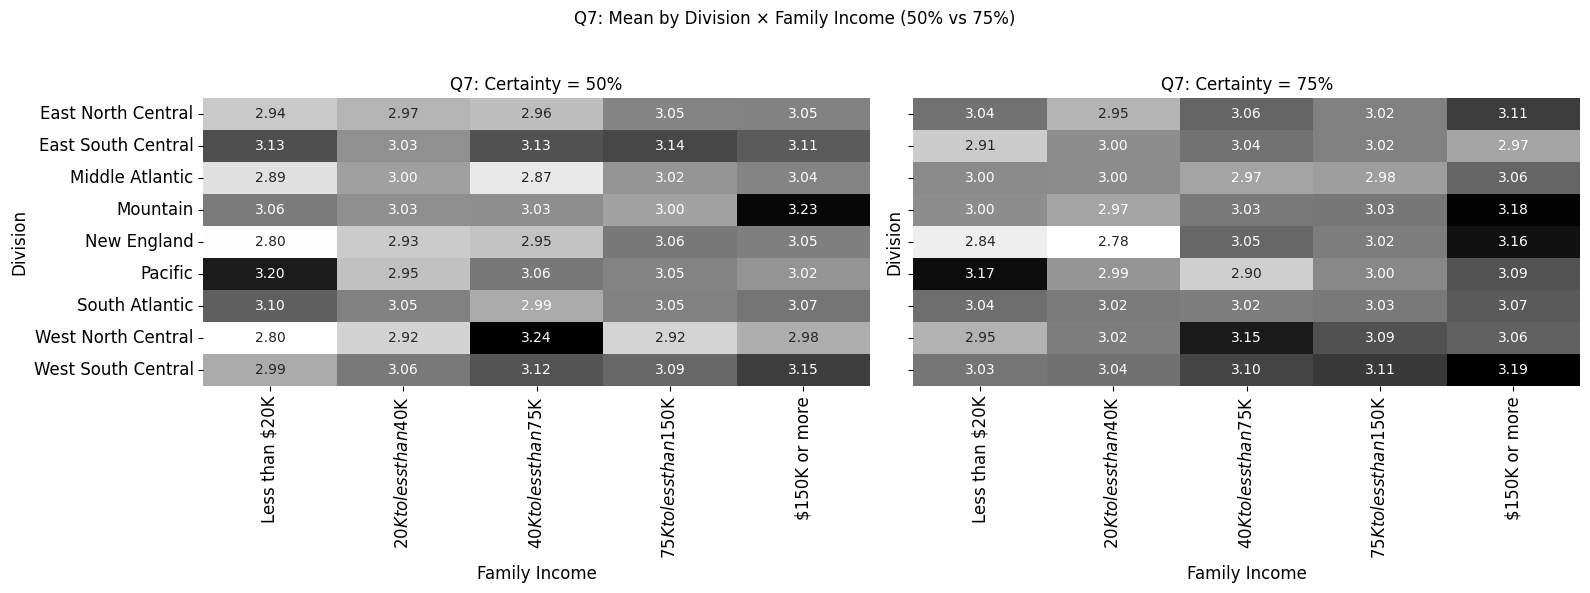

/tmp/ipython-input-2997694932.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_50.groupby(["DIVISION", "FAMINC5"])[score]
/tmp/ipython-input-2997694932.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_75.groupby(["DIVISION", "FAMINC5"])[score]


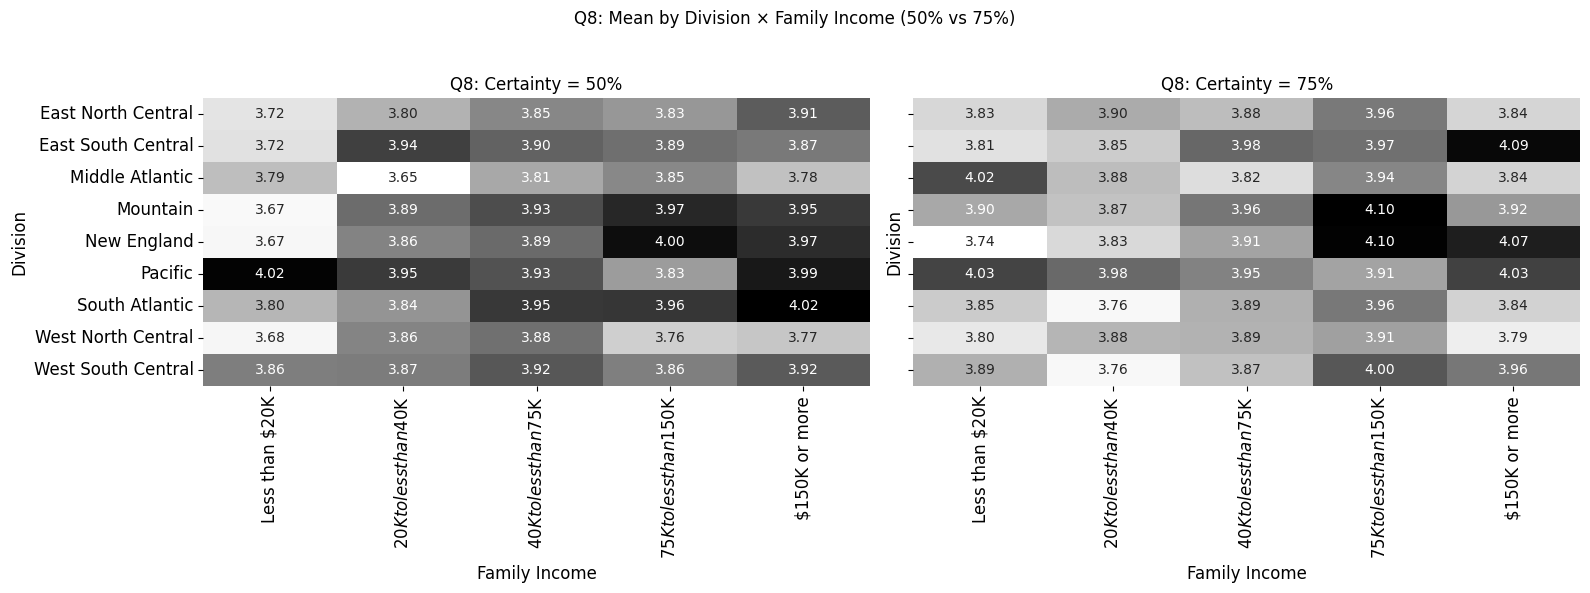

Saved ./Heatmaps_Certainty.pdf


In [51]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_heatmap_certainty_side_by_side(
    df,
    questions,
    mask_zeros=True,
    save=False,
    outdir=".",
    fontsize=12,
    figsize=(16, 6),
    dpi=100,
    save_dpi=300
):
    canonical_levels = [
        "Less than $20K",
        "$20K to less than $40K",
        "$40K to less than $75K",
        "$75K to less than $150K",
        "$150K or more",
    ]

    pdf = None
    if save:
        os.makedirs(outdir, exist_ok=True)
        pdf_path = f"{outdir}/Heatmaps_Certainty.pdf"
        pdf = PdfPages(pdf_path)

    for score in questions:
        df_copy = df.copy()
        if mask_zeros and score in df_copy:
            df_copy.loc[df_copy[score] == 0, score] = np.nan

        df_copy["FAMINC5"] = pd.Categorical(
            df_copy["FAMINC5"], categories=canonical_levels, ordered=True
        )

        df_50 = df_copy[df_copy["Certainty"] == 50]
        df_75 = df_copy[df_copy["Certainty"] == 75]

        means_50 = (
            df_50.groupby(["DIVISION", "FAMINC5"])[score]
                 .mean()
                 .unstack()
                 .reindex(columns=canonical_levels)
        )
        means_75 = (
            df_75.groupby(["DIVISION", "FAMINC5"])[score]
                 .mean()
                 .unstack()
                 .reindex(columns=canonical_levels)
        )

        fig, axes = plt.subplots(1, 2, figsize=figsize, dpi=dpi, sharey=True)

        ax0 = axes[0]
        sns.heatmap(means_50, annot=True, fmt=".2f", cmap="Greys", cbar=False, ax=ax0)
        ax0.set_title(f"{score}: Certainty = 50%", fontsize=fontsize)
        ax0.set_xlabel("Family Income", fontsize=fontsize)
        ax0.set_ylabel("Division", fontsize=fontsize)
        ax0.tick_params(axis='both', labelsize=fontsize)

        ax1 = axes[1]
        sns.heatmap(means_75, annot=True, fmt=".2f", cmap="Greys", cbar=False, ax=ax1)
        ax1.set_title(f"{score}: Certainty = 75%", fontsize=fontsize)
        ax1.set_xlabel("Family Income", fontsize=fontsize)
        ax1.set_ylabel("Division", fontsize=fontsize)
        ax1.tick_params(axis='both', labelsize=fontsize)

        plt.suptitle(f"{score}: Mean by Division × Family Income (50% vs 75%)", fontsize=fontsize)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if save:
            pdf.savefig(fig, bbox_inches="tight", dpi=save_dpi)

        plt.show()
        plt.close(fig)

    if save:
        pdf.close()
        print(f"Saved {pdf_path}")

# --- Example usage ---
questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]
plot_heatmap_certainty_side_by_side(df_final, questions, save=True, outdir=".")

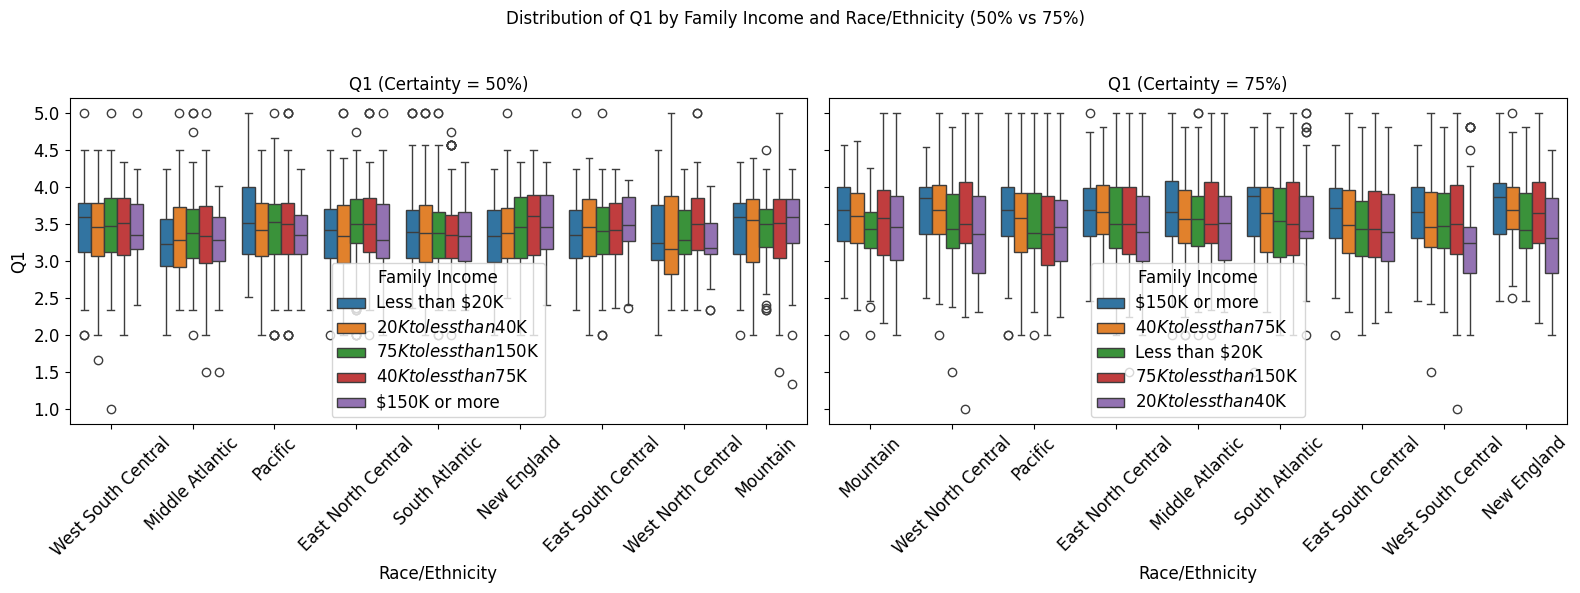

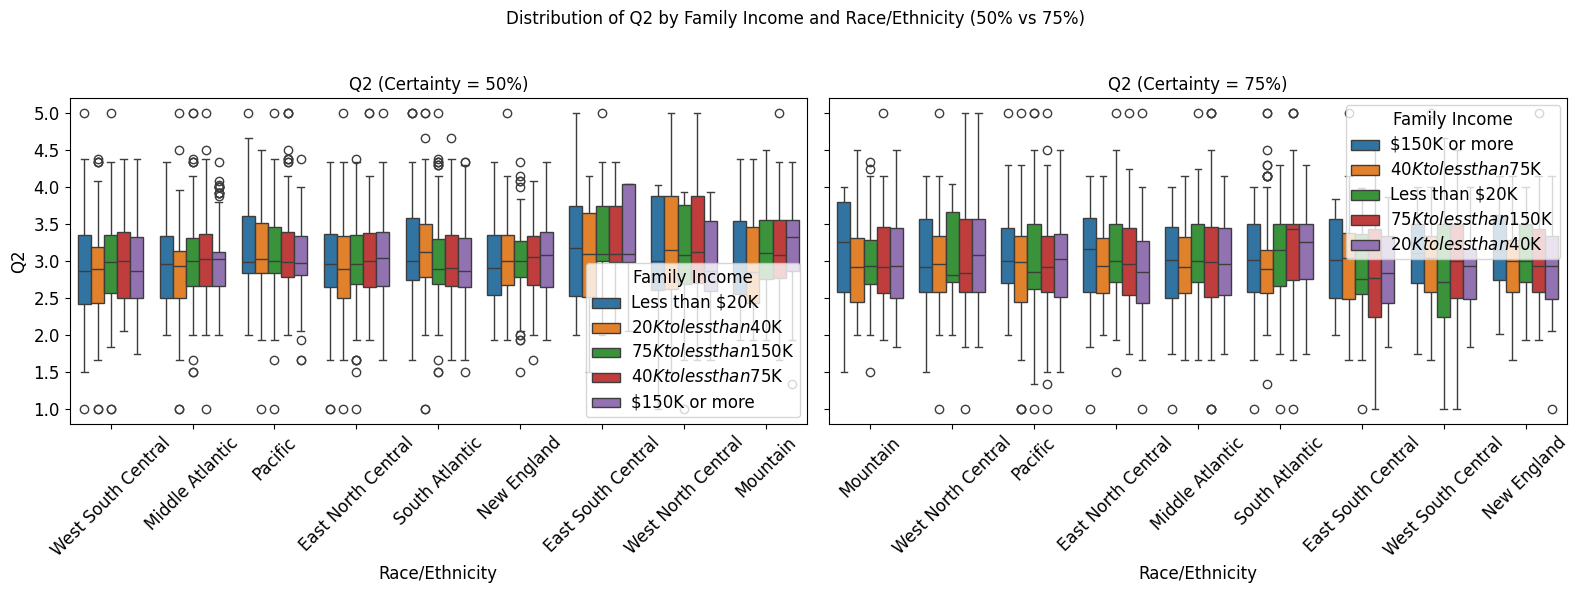

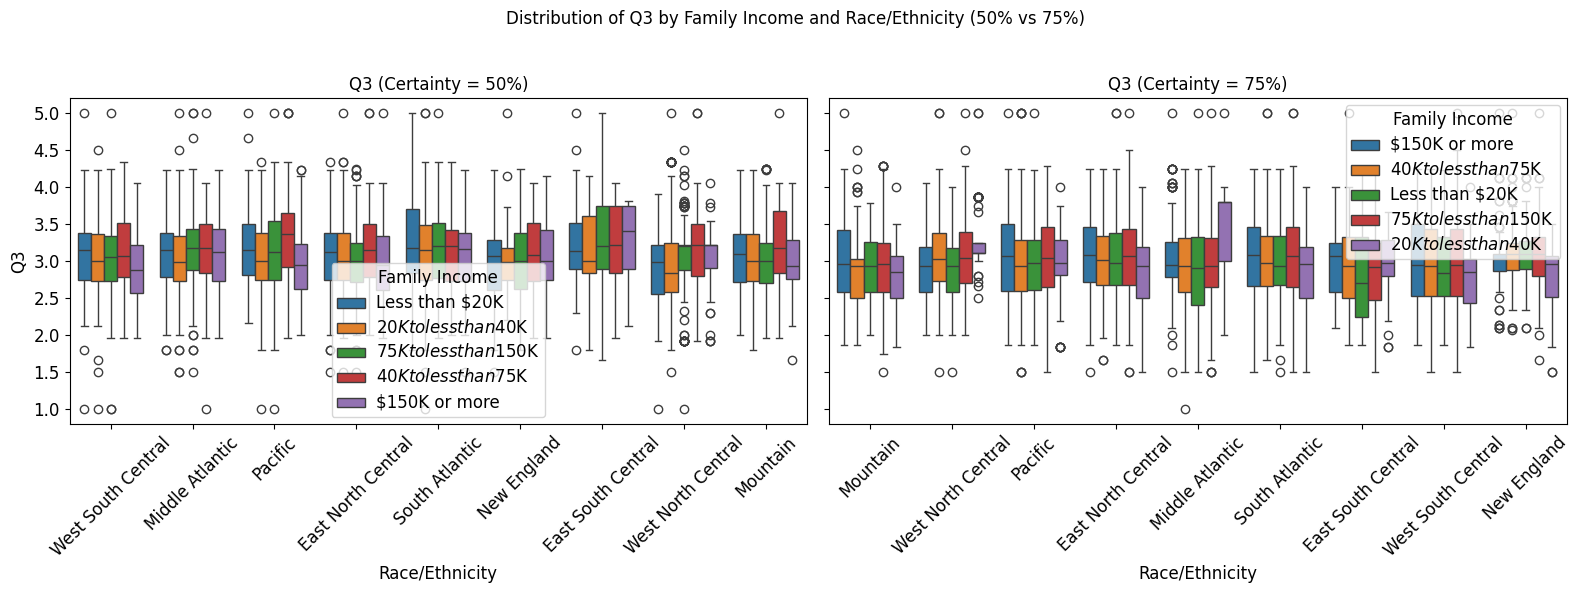

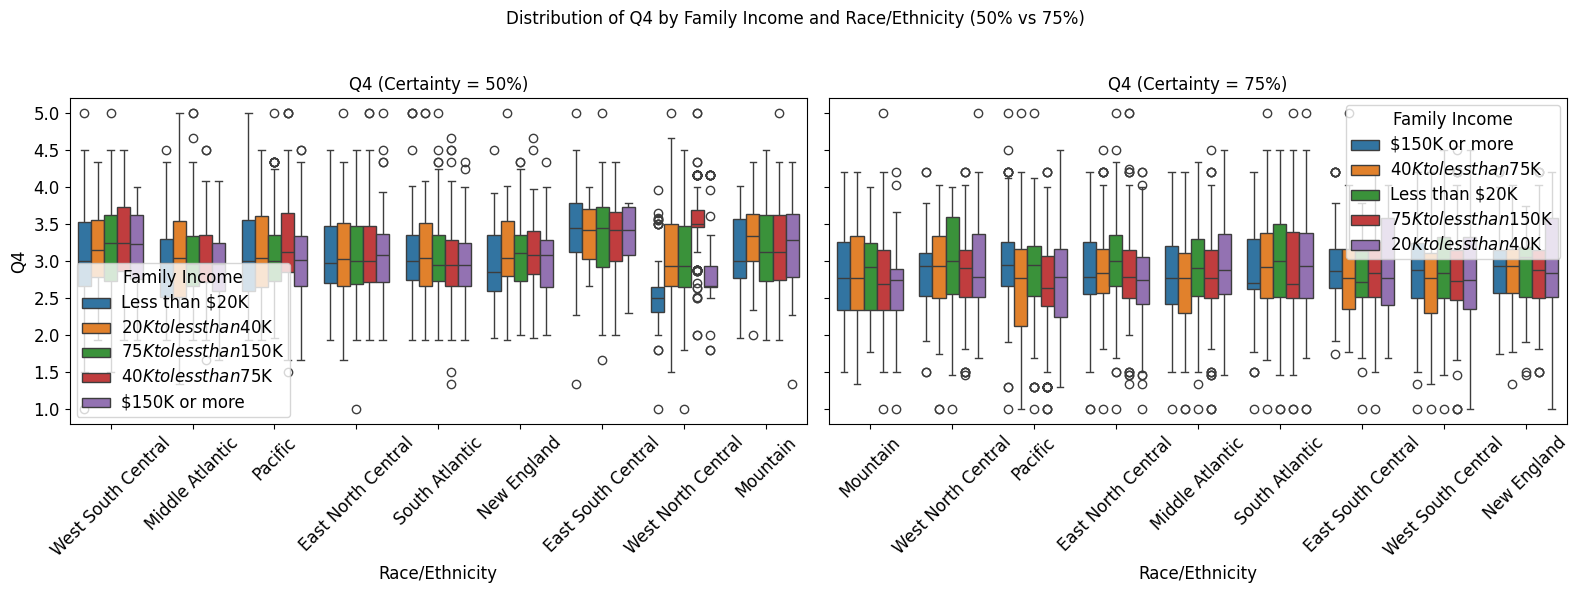

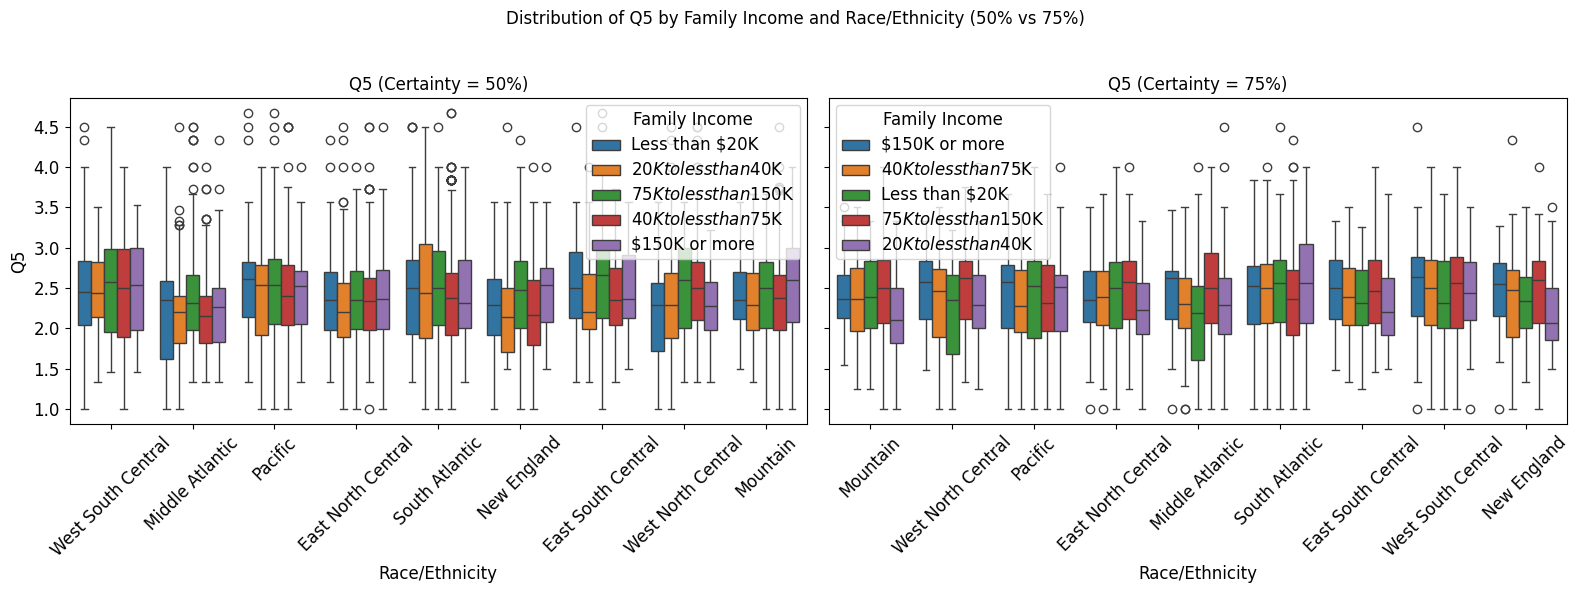

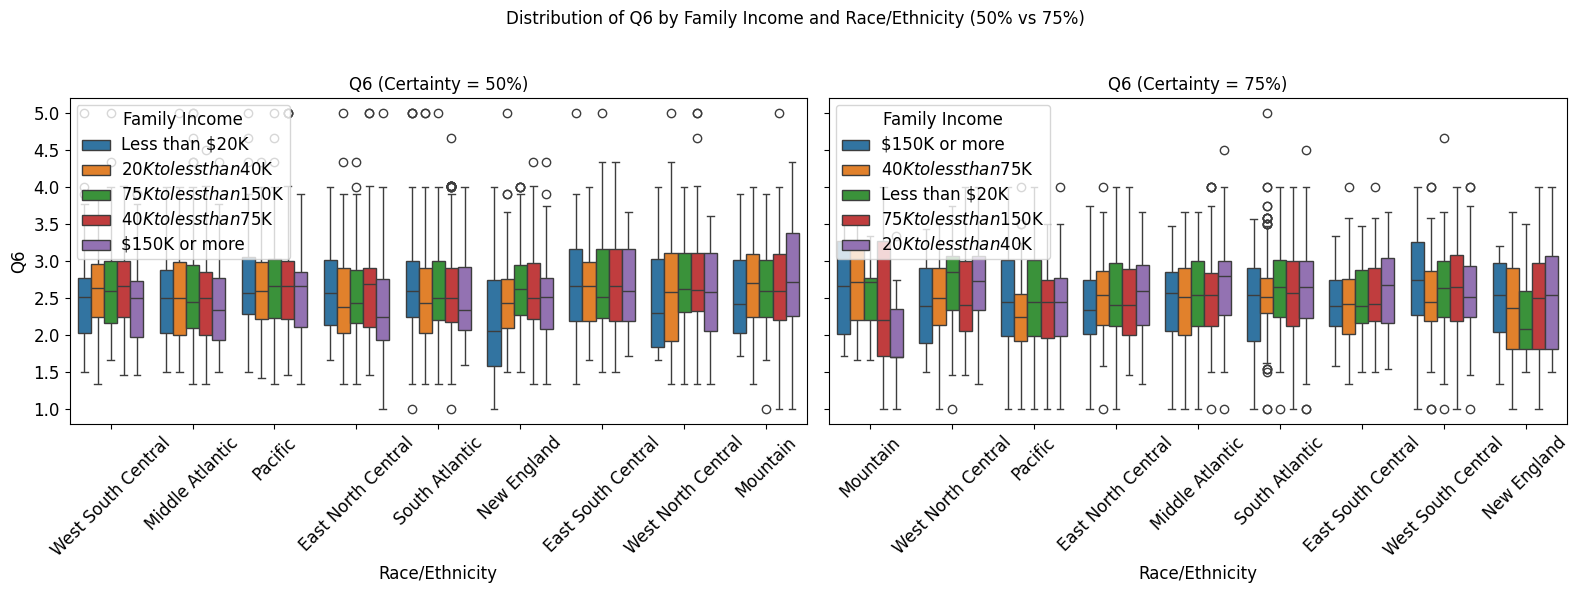

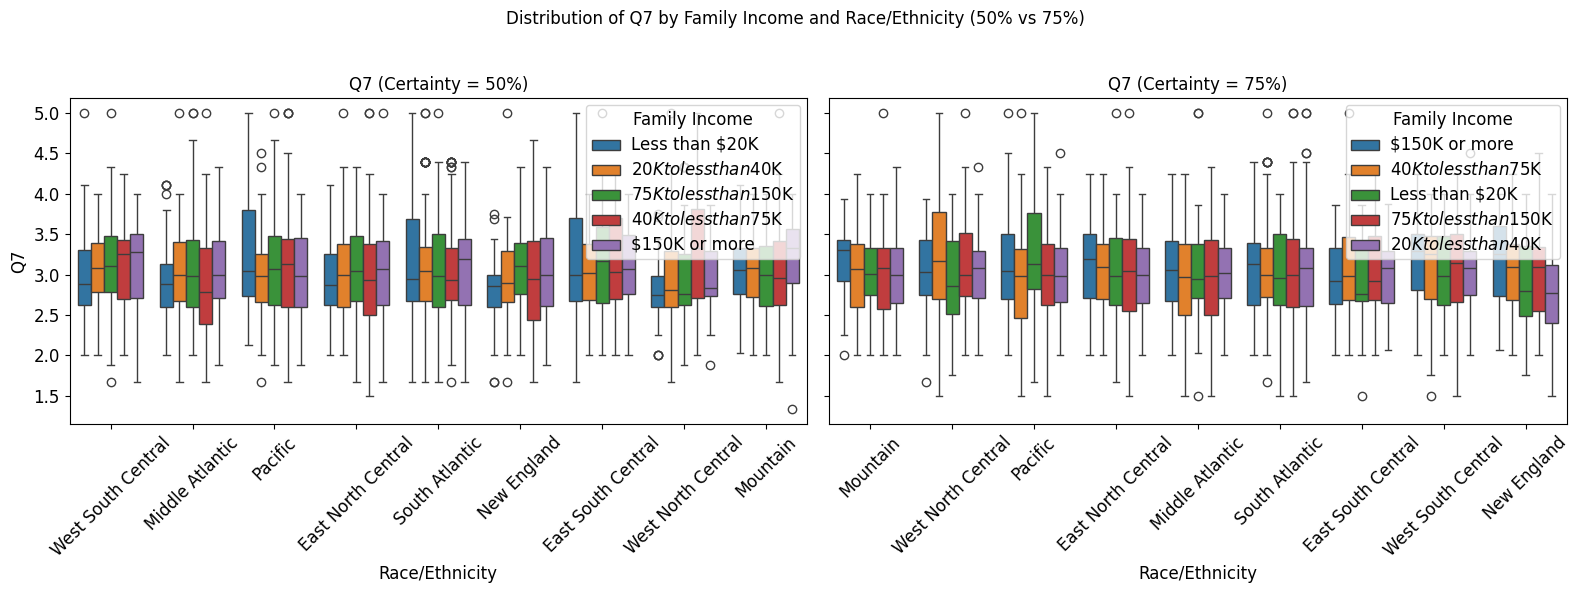

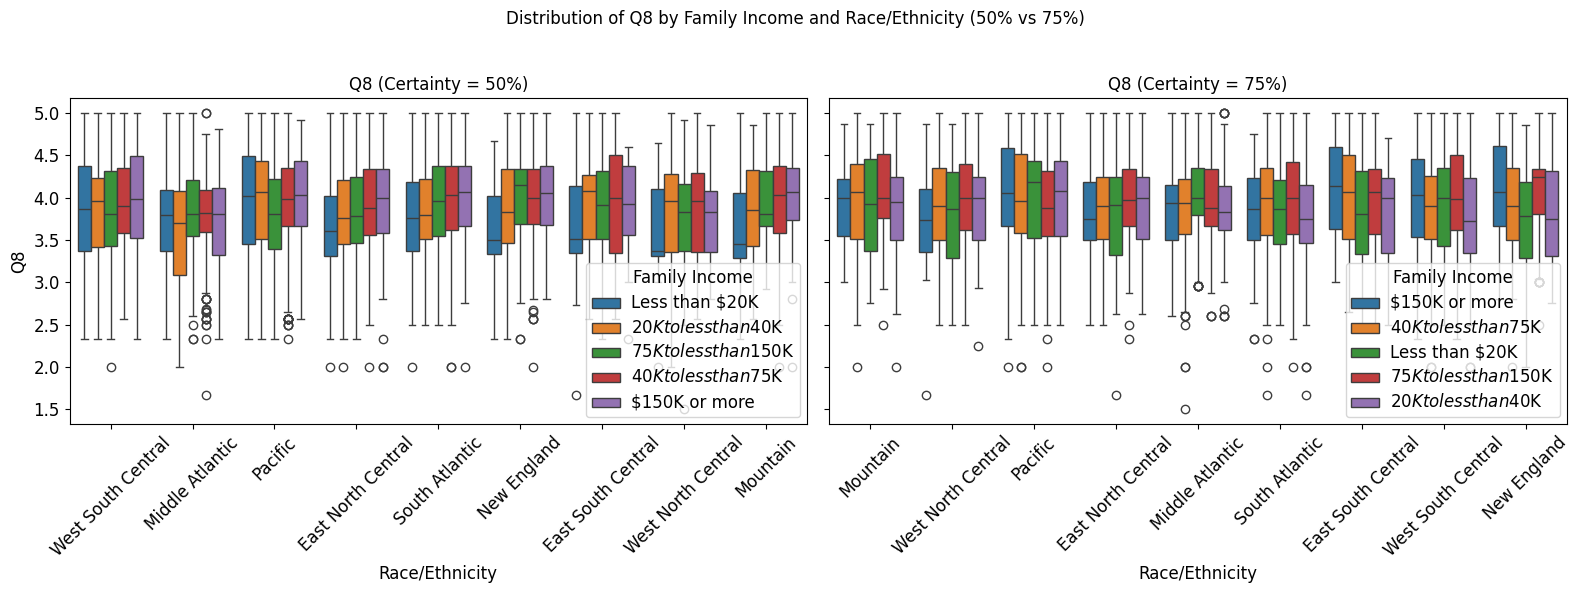

Saved ./Boxplots_Certainty.pdf


In [48]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_boxplot_certainty_side_by_side(df, questions, save=False, outdir=".", fontsize=12, figsize=(16, 6), dpi=100, save_dpi=300):
    pdf = None
    if save:
        os.makedirs(outdir, exist_ok=True)
        pdf_path = f"{outdir}/Boxplots_Certainty.pdf"
        pdf = PdfPages(pdf_path)

    for score in questions:
        df_50 = df[df["Certainty"] == 50]
        df_75 = df[df["Certainty"] == 75]

        fig, axes = plt.subplots(1, 2, figsize=figsize, dpi=dpi, sharey=True)

        ax0 = sns.boxplot(x="DIVISION", y=score, hue="FAMINC5", data=df_50, ax=axes[0])
        ax0.set_title(f"{score} (Certainty = 50%)", fontsize=fontsize)
        ax0.set_xlabel("Race/Ethnicity", fontsize=fontsize)
        ax0.set_ylabel(score, fontsize=fontsize)
        ax0.tick_params(axis="both", labelsize=fontsize)
        axes[0].tick_params(axis="x", rotation=45)
        leg0 = ax0.legend(title="Family Income")
        if leg0:
            leg0.get_title().set_fontsize(fontsize)
            for t in leg0.get_texts():
                t.set_fontsize(fontsize)

        ax1 = sns.boxplot(x="DIVISION", y=score, hue="FAMINC5", data=df_75, ax=axes[1])
        ax1.set_title(f"{score} (Certainty = 75%)", fontsize=fontsize)
        ax1.set_xlabel("Race/Ethnicity", fontsize=fontsize)
        ax1.set_ylabel(score, fontsize=fontsize)
        ax1.tick_params(axis="both", labelsize=fontsize)
        axes[1].tick_params(axis="x", rotation=45)
        leg1 = ax1.legend(title="Family Income")
        if leg1:
            leg1.get_title().set_fontsize(fontsize)
            for t in leg1.get_texts():
                t.set_fontsize(fontsize)

        plt.suptitle(f"Distribution of {score} by Family Income and Race/Ethnicity (50% vs 75%)", fontsize=fontsize)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if save:
            pdf.savefig(fig, bbox_inches="tight", dpi=save_dpi)

        plt.show()
        plt.close(fig)

    if save:
        pdf.close()
        print(f"Saved {pdf_path}")

# --- Example usage ---
questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]
plot_boxplot_certainty_side_by_side(df_final, questions, save=True, outdir=".")

/usr/local/lib/python3.12/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


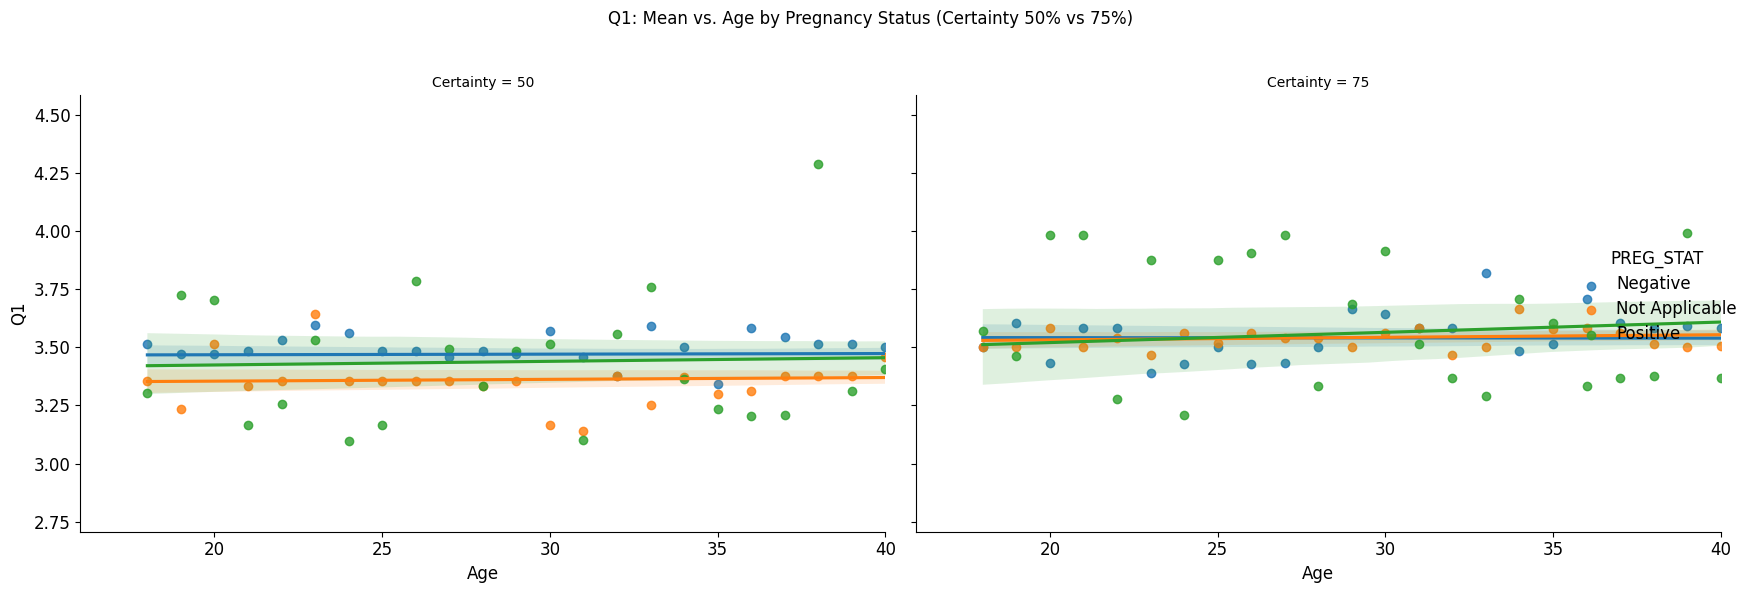

/usr/local/lib/python3.12/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


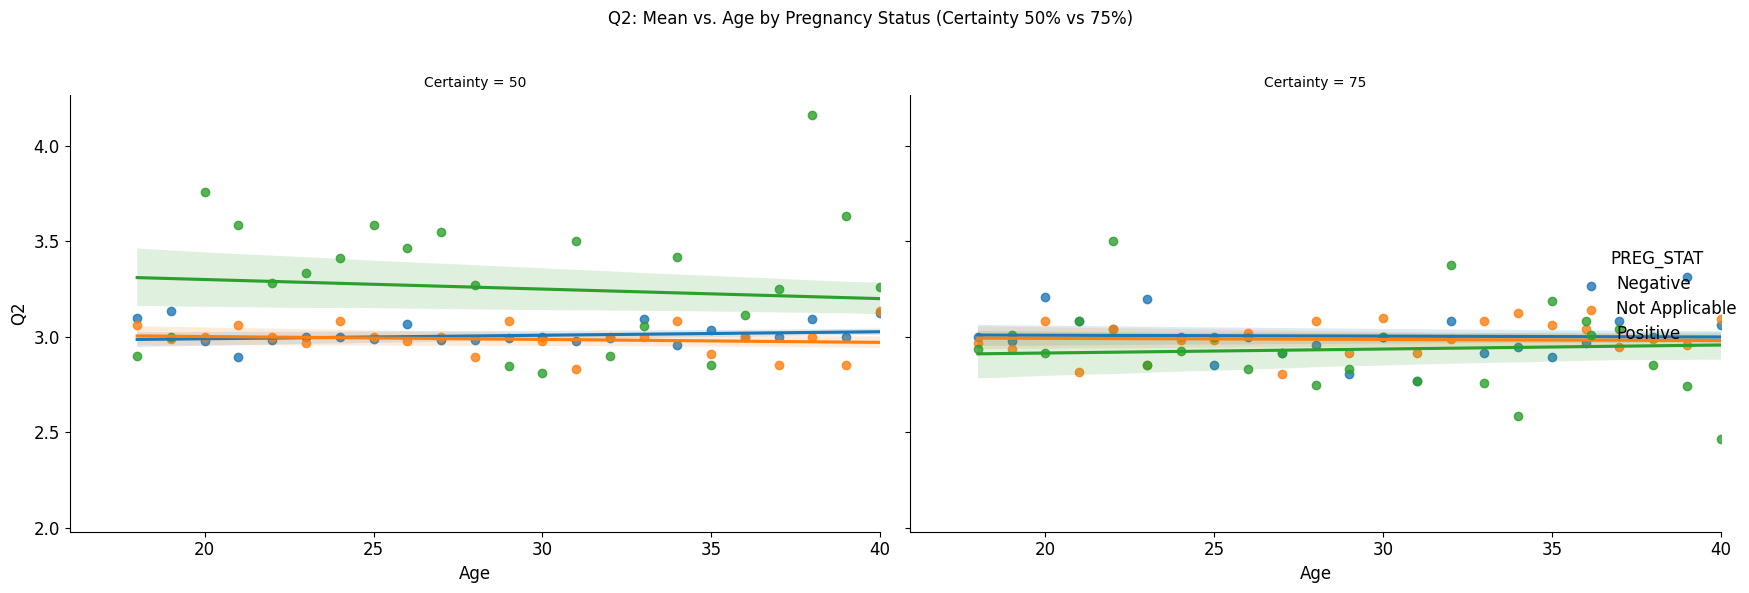

/usr/local/lib/python3.12/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


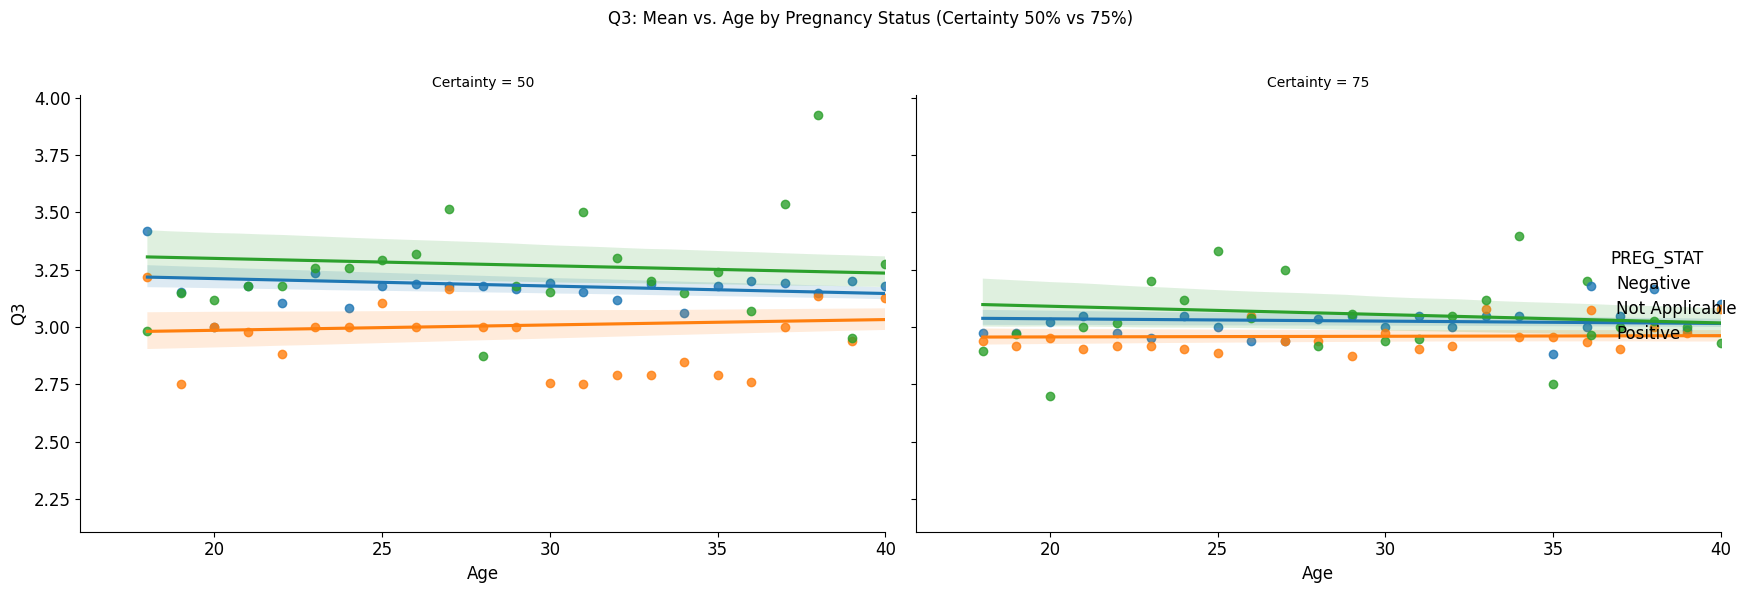

/usr/local/lib/python3.12/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


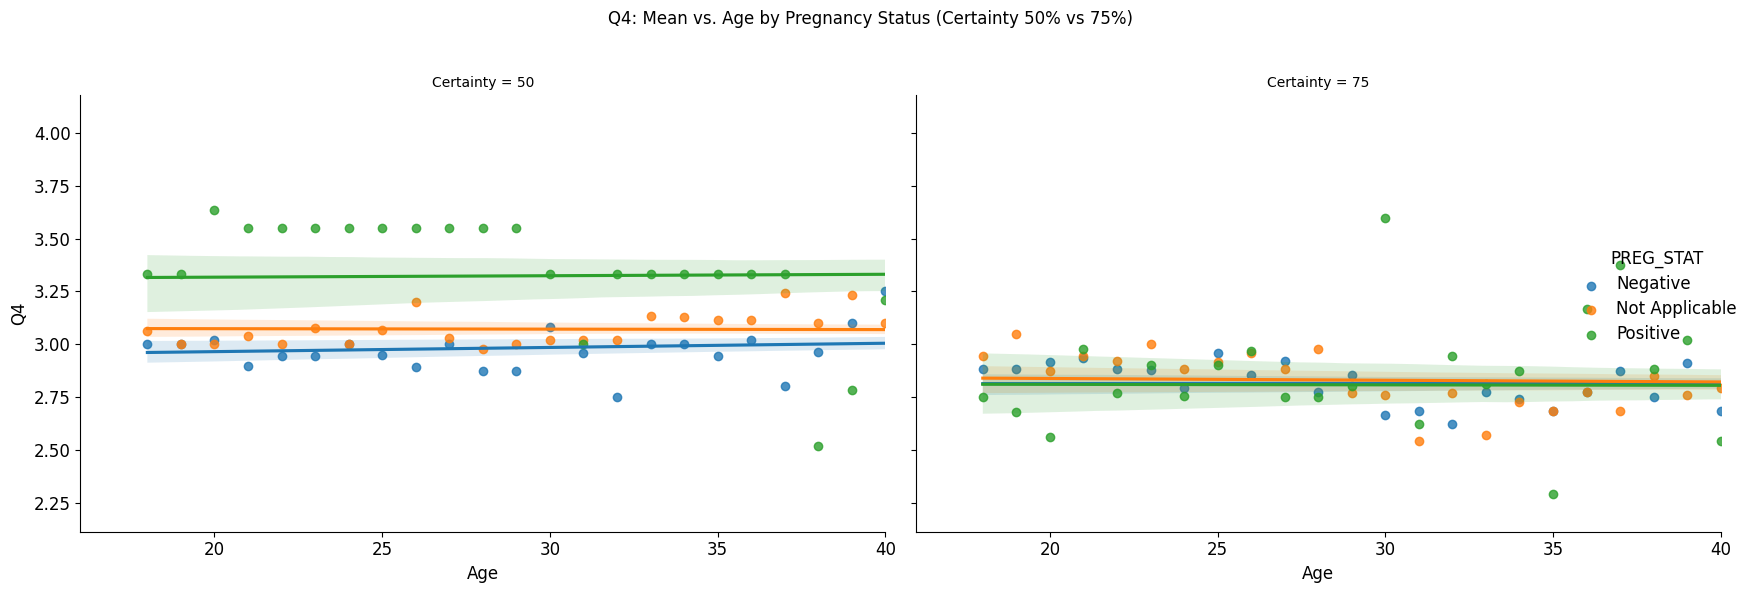

/usr/local/lib/python3.12/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


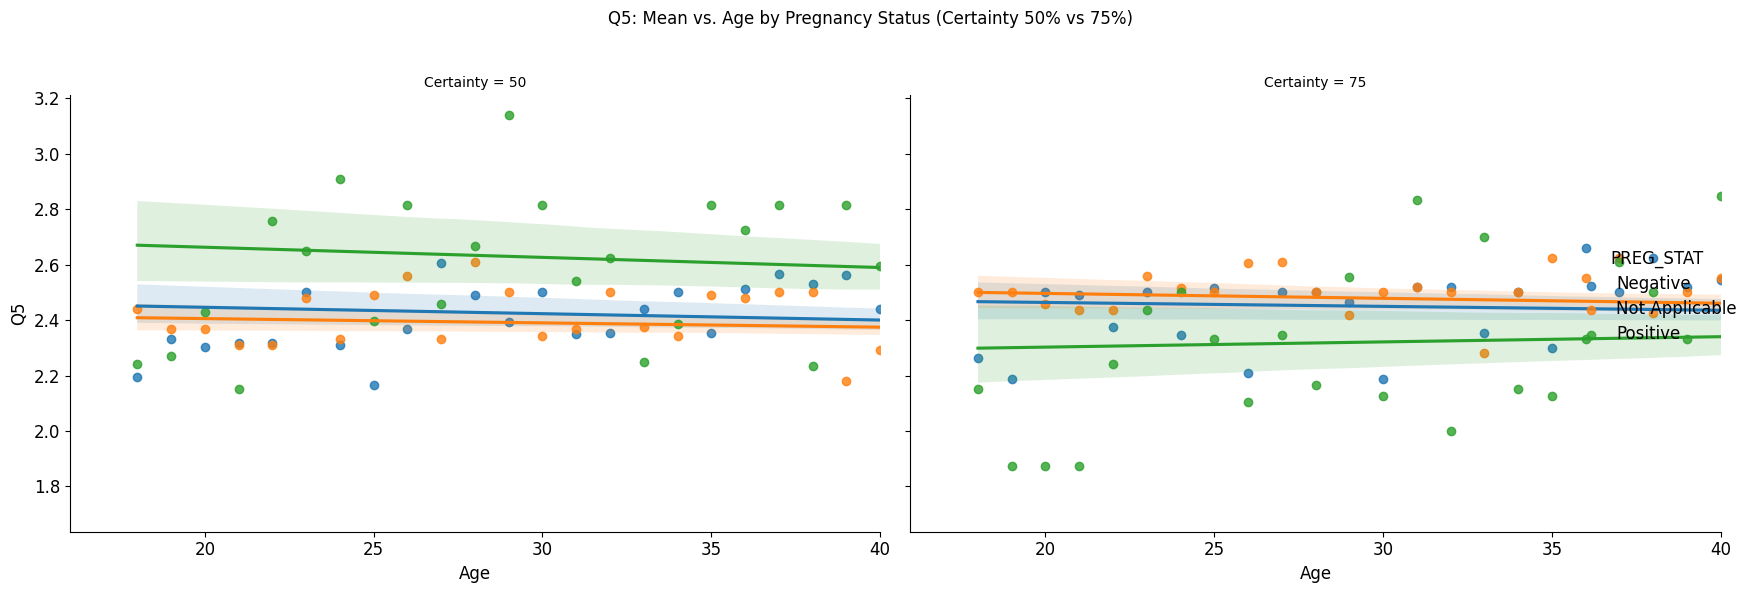

/usr/local/lib/python3.12/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


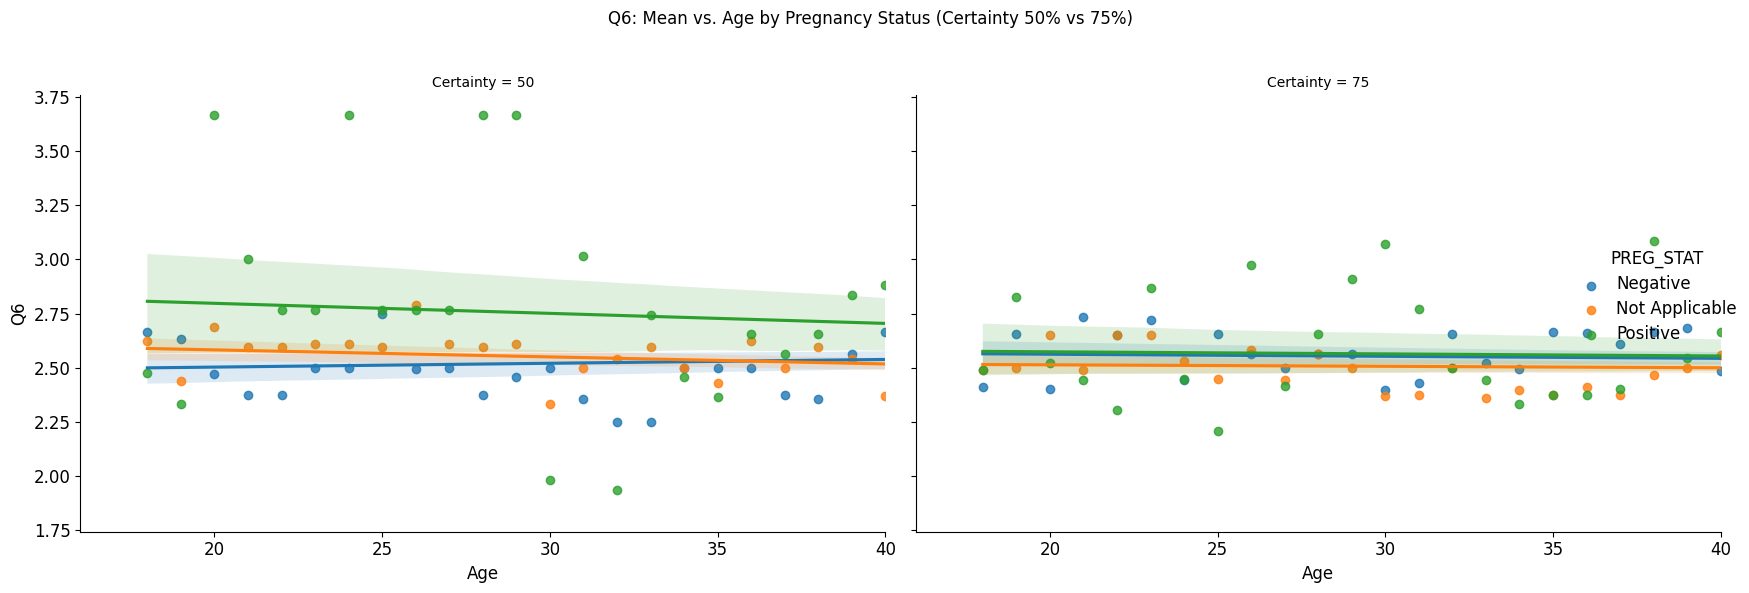

/usr/local/lib/python3.12/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


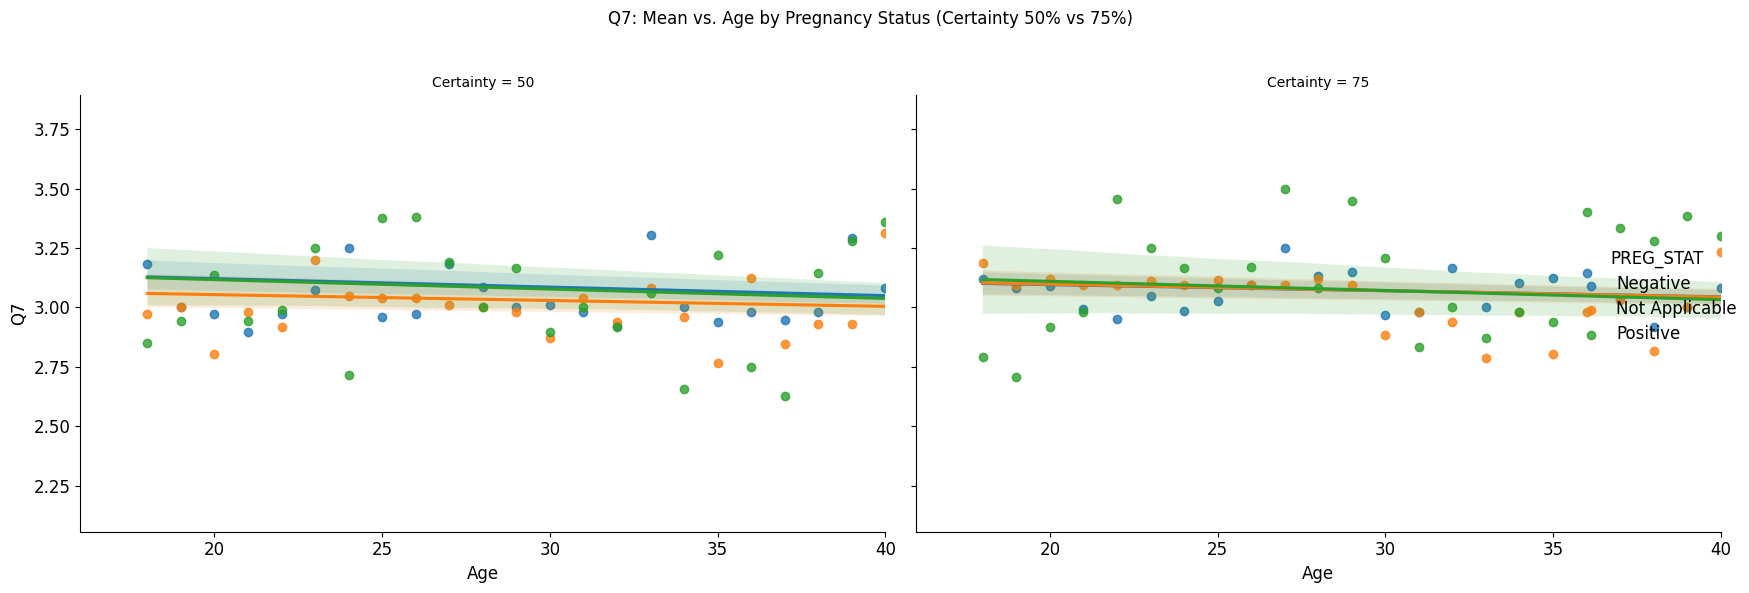

/usr/local/lib/python3.12/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


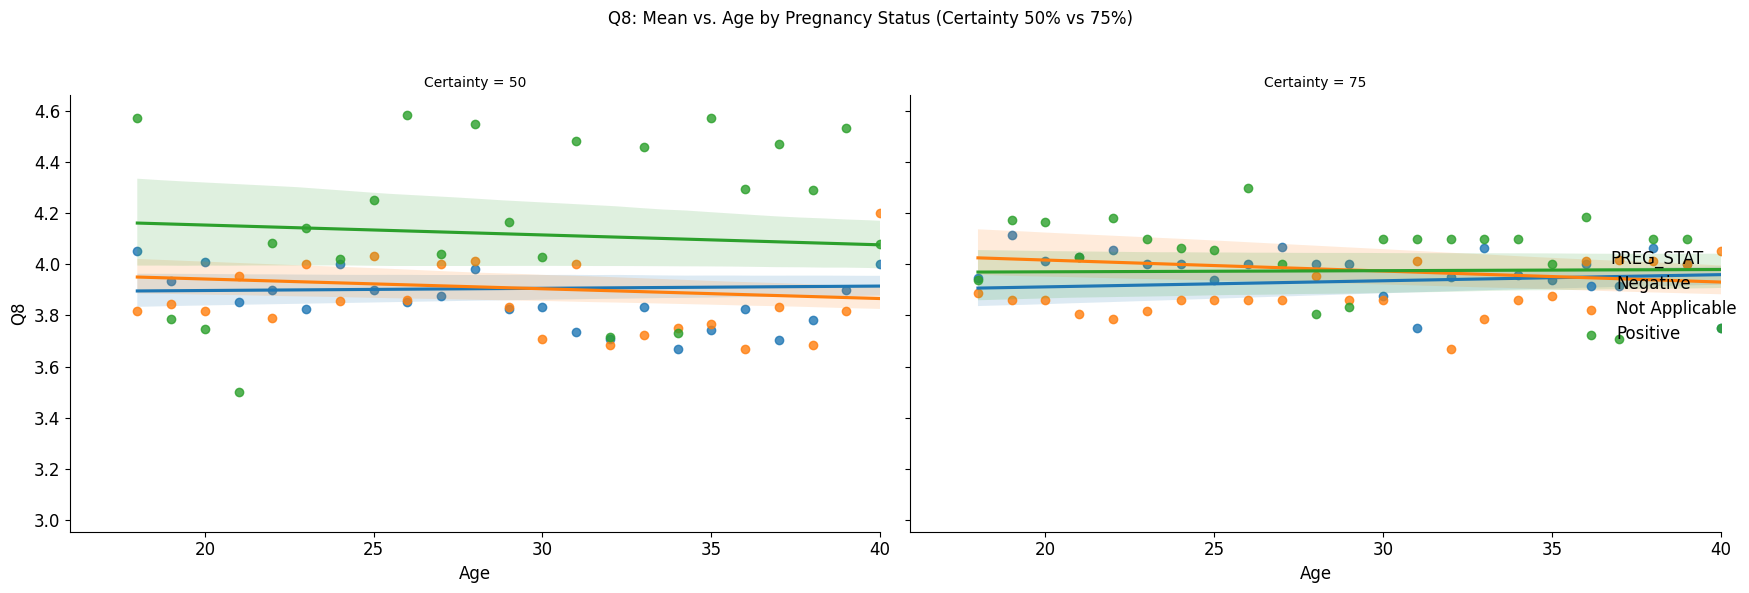

Saved ./LinearPlots_Certainty.pdf


In [49]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_linear_certainty_side_by_side(df, questions, save=False, outdir=".", fontsize=12, figsize=(16, 6), dpi=100, save_dpi=300):
    pdf = None
    if save:
        os.makedirs(outdir, exist_ok=True)
        pdf_path = f"{outdir}/LinearPlots_Certainty.pdf"
        pdf = PdfPages(pdf_path)

    for score in questions:
        sub = df[df["Certainty"].isin([50, 75])].copy()
        grouped = sub.groupby(["Certainty", "AGE", "PREG_STAT"])[score].median().reset_index()

        height = figsize[1]
        aspect = figsize[0] / (2 * height)

        g = sns.lmplot(
            x="AGE",
            y=score,
            data=grouped,
            hue="PREG_STAT",
            col="Certainty",
            col_order=[50, 75],
            height=height,
            aspect=aspect,
            legend_out=True
        )
        g.fig.set_dpi(dpi)

        g.set(xlim=(16, 40))
        g.set_xlabels("Age", fontsize=fontsize)
        g.set_ylabels(score, fontsize=fontsize)
        for ax in g.axes.flat:
            ax.tick_params(axis="both", labelsize=fontsize)

        if g._legend is not None:
            g._legend.set_title("PREG_STAT")
            g._legend.get_title().set_fontsize(fontsize)
            for t in g._legend.get_texts():
                t.set_fontsize(fontsize)

        plt.suptitle(f"{score}: Mean vs. Age by Pregnancy Status (Certainty 50% vs 75%)", fontsize=fontsize)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if save:
            pdf.savefig(g.fig, bbox_inches="tight", dpi=save_dpi)

        plt.show()
        plt.close(g.fig)

    if save:
        pdf.close()
        print(f"Saved {pdf_path}")

# --- Example usage ---
questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]
plot_linear_certainty_side_by_side(df_final, questions, save=True, outdir=".")

Does certainty of 50 vs 75 produce significantly diff harm scores? In almost all cases, it does.

In [50]:
import itertools
from scipy import stats

score_types = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

for score in score_types:
    # Separate data for 50% vs 75% certainty
    data_50 = df_final[df_final['Certainty'] == 50][score].dropna()
    data_75 = df_final[df_final['Certainty'] == 75][score].dropna()

    # Only run a t-test if both groups have sufficient data
    if len(data_50) >= 2 and len(data_75) >= 2:
        t_stat, p_val = stats.ttest_ind(data_50, data_75, equal_var=False)
        print(f"{score} | t = {t_stat:.3f}, p = {p_val:.3e}")
    else:
        print(f"{score} | Not enough data for t-test.")

Q1 | t = -19.103, p = 1.297e-80
Q2 | t = 5.746, p = 9.288e-09
Q3 | t = 15.440, p = 1.810e-53
Q4 | t = 31.583, p = 1.207e-213
Q5 | t = 1.004, p = 3.152e-01
Q6 | t = 11.524, p = 1.248e-30
Q7 | t = 0.077, p = 9.388e-01
Q8 | t = -5.171, p = 2.347e-07
